In [1]:
from Common_functions import  localize_event

%matplotlib inline

In [2]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
from tqdm import tqdm
import scipy.stats as st
from os.path import expanduser
import cmath
from scipy import optimize
import time
import gzip
from scipy.interpolate import interp1d
import pandas as pd
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition) 
import traceback
from lmfit import minimize, Parameters, Parameter, report_fit


%matplotlib inline
home = os.path.expanduser("~")

In [3]:
def calc_chisq(lightcurve,fx,ftype = 'm'):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""
    if ftype=='m':
        chisq = ((lightcurve[:,1] - fx)**2 / fx).sum()
        
    if ftype=='A':
        chisq = ((lightcurve[:,3] - fx)**2 / fx).sum()
    
    return chisq
    
def bell_curve(x,a,b,c,d):
    """Function describing a bell curve of the form:
    f(x; a,b,c,d) = d / [1 + |(x-c)/a|^(2b)]
    
    Inputs:
    :param  np.array x: Series of intervals at which the function should
                        be evaluated
    :param float a,b,c: Coefficients of the bell curve function
    
    Returns:
    :param np.array f(x): Series of function values at the intervals in x
    """
    
    fx = d / ( 1.0 + (abs( (x-c)/a ))**(2.0*b) )
    
    return fx

def gaussian(x,a,b,c):
    """Function describing a Gaussian of the form:
    f(x; a,b,c) = a * exp(-(x-b)**2/2c*2)
    
    Inputs:
    :param  np.array x: Series of intervals at which the function should
                        be evaluated
    :param float a,b,c: Coefficients of the bell curve function
    
    Returns:
    :param np.array f(x): Series of function values at the intervals in x
    """
    
    fx = a * np.exp(-( (x-b)**2 / (2*c*c) ))
    
    return fx

def PSPL (x,t0,u0,tE):
    u = np.sqrt(u0**2+((x-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    #fx = base*np.ones(len(x)) + (-2.5 * np.log10(A))

    return A

def localize_event(lightcurve,t0, dt=10):
    """Function to estimate roughly the area around the peak of an event, 
    and identify which timestamps in the array belong to the event versus
    the baseline
    """
    
    idx1 = np.where(lightcurve[:,0] >= t0-dt)[0]
    idx2 = np.where(lightcurve[:,0] <= t0+dt)[0]
    event = list(set(idx1).intersection(set(idx2)))
    
    baseline = np.arange(0,len(lightcurve),1)
    baseline = np.delete(baseline,event)
    
    it0 = np.where(lightcurve[:,0] == t0)[0][0]
    
    return baseline, event, it0
    
def estimate_init_param(lightcurve, t0, model, baseline,event,it0):
    """Function to provide rough estimates of the model parameters
    prior to fitting.
    
    Model parameter indicates which order in the coefficients array
    should be used, appropriate to model = { gaussian, bellcurve }
    options.
    """
    
    a = np.median(lightcurve[baseline,1]) - lightcurve[it0,1]

    half_mag = np.median(lightcurve[baseline,1]) - (a/1.2)
    dm = abs(lightcurve[:,1] - half_mag)
    idx = dm.argsort()
#     base = np.round(np.median(lightcurve[baseline,1]),4)
#     mag_peak = min(lightcurve[:,1][event])
#     A_max = 10 ** (0.4*(base - mag_peak))
    u0_ini = np.sqrt( ( (1+np.sqrt(1+16*(max(lightcurve[:,3])**2)))/(2* max(lightcurve[:,3])) ) - 2 )
    #print u0_ini
    
    
    dt = abs(lightcurve[idx[0],0] - lightcurve[idx[1],0])
    
    if model == 'gaussian':
        g_init_par = [ a, 0.0, dt ]
    
    elif model == 'bellcurve':
        g_init_par = [ dt, 1.0, 0.0, a]
        
    elif model == 'PSPL':
        g_init_par = [ 0.0, u0_ini, dt]
      
        
    else:
        raise RuntimeError('Unrecognised model type '+model)
        
    return g_init_par



In [4]:

def generate_microlensing_lightcurve(u0, ndp, diagnostics=False):
    """Function to generate a microlensing lightcurve for testing purposes.
    
    WARNING: Full photometric uncertainties not implemented as not currently
    necessary for testing purposes.
    
    Inputs:
    :param float u0: Event impact parameter
    :param int ndp:  Number of datapoints in the lightcurve
    
    Returns:
    :param np.array lightcurve: Timeseries photmetry 3-column array
                                (timestamp, mag/flux, mag error/flux error)
                                for N datapoints
    """

    lightcurve = np.zeros((ndp,3))
    
    lightcurve[:,0] = np.linspace(2459000.0, 2459040.0, ndp)
    
    u = np.linspace(0.01, 10.0, int(float(ndp)/2))
    u = np.concatenate([u[::-1],u])

    lightcurve[:,1] = np.random.normal(16.0, 0.003, size=ndp)
    lightcurve[:,1] += -2.5 * np.log10(microlensing_magnification(u))
    
    peaks = np.zeros(1)
    peaks[0] = lightcurve[int(float(ndp)/2),0]
    
    lightcurve[:,2] = np.random.normal(lightcurve[:,1],0.001)

    if diagnostics:
        fig = plt.figure(1,(10,10))
        plt.plot(lightcurve[:,0],microlensing_magnification(u))
        plt.xlabel('HJD')
        plt.ylabel('Mag')
        plt.show()
    
    return lightcurve, peaks
    
def microlensing_magnification(u):
    """Function to calculate the microlensing magnification for a range of 
    angular projected separations between lens and source, u"""
    
    A = ((u*u) + 2) / (u * np.sqrt(u*u + 4))
    
    return A

In [5]:
home = os.path.expanduser("~")

In [6]:
# Set up te directory where all microlensing data challenge lightcurves are

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/lc/'
direc = os.listdir(temp)

In [7]:
lightcurve, peaks = generate_microlensing_lightcurve(0.6, 400)

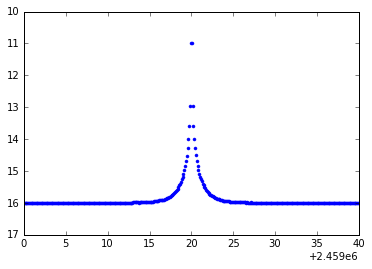

In [8]:
plt.plot(lightcurve[:,0], lightcurve[:,1],'b.')
plt.gca().invert_yaxis()

In [8]:
(baseline, event, it0) = localize_event(lightcurve,peaks[0])

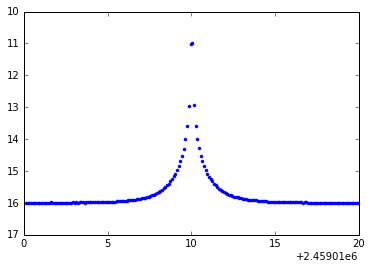

In [9]:
plt.plot(lightcurve[event,0], lightcurve[event,1],'b.')
plt.gca().invert_yaxis()

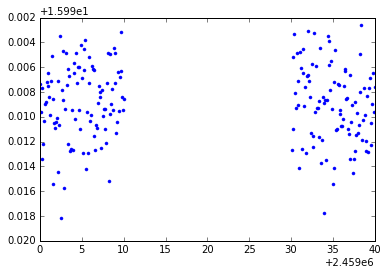

In [10]:
plt.plot(lightcurve[baseline,0], lightcurve[baseline,1],'b.')
plt.gca().invert_yaxis()

In [11]:
g_init_par = estimate_init_param(lightcurve, peaks[0], 'gaussian',
                                         baseline, event, it0)

IndexError: index 3 is out of bounds for axis 1 with size 3

In [12]:
g_init_par

NameError: name 'g_init_par' is not defined

In [13]:
gfx = gaussian(lightcurve[:,0]-peaks[0],g_init_par[0],g_init_par[1],g_init_par[2])
gfx = np.median(lightcurve[baseline,1]) - gfx

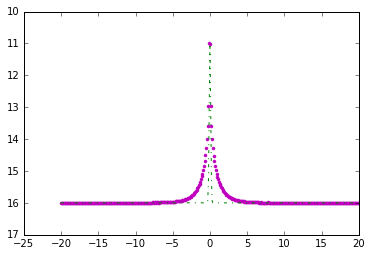

In [14]:
plt.plot(lightcurve[:,0]-peaks[0],lightcurve[:,1],'m.')
plt.plot(lightcurve[:,0]-peaks[0],gfx,'g-.')
plt.gca().invert_yaxis()

In [15]:
g_init_par

[4.994034281781049, 0.0, 0.10025062691420317]

In [16]:
(gfit,gcov) = optimize.curve_fit(gaussian,lightcurve[event,0]-peaks[0],
                                          -lightcurve[event,1]+np.median(lightcurve[baseline,1]),
                                         p0=g_init_par)

In [17]:
gfit

array([ 3.30413223, -0.05031253,  0.52985369])

In [18]:
gfx2 = gaussian(lightcurve[:,0]-peaks[0],gfit[0],gfit[1],gfit[2])
gfx2 = -gfx2+np.median(lightcurve[baseline,1])

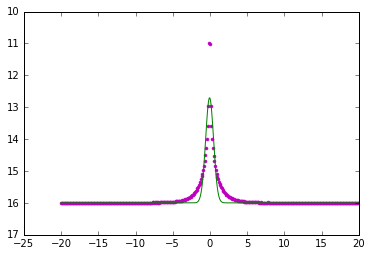

In [19]:
plt.plot(lightcurve[:,0]-peaks[0],lightcurve[:,1],'m.')
#plt.plot(lightcurve[:,0],gfx,'g-.')
plt.plot(lightcurve[:,0]-peaks[0],gfx2,'g-')
plt.gca().invert_yaxis()

In [20]:
g_chisq = calc_chisq(lightcurve,gfx2)

In [21]:
b_init_par = estimate_init_param(lightcurve, peaks[0], 'bellcurve',
                                         baseline, event, it0)

#b_init_par = [3.0,1.0,0.0,4.0]

(bfit,bcov) = optimize.curve_fit(bell_curve,lightcurve[event,0]-peaks[0],
                                                -lightcurve[event,1]+np.median(lightcurve[baseline,1]),
                                                 p0=b_init_par)        

In [22]:
np.shape(b_init_par)

(4,)

In [23]:
bfx = bell_curve(lightcurve[:,0]-peaks[0],bfit[0],bfit[1],bfit[2],bfit[3])
bfx = np.median(lightcurve[baseline,1]) - bfx

In [24]:
bfit

array([ 0.22634726,  0.63579787, -0.05021352,  5.49932344])

In [25]:
b_chisq = calc_chisq(lightcurve,bfx)

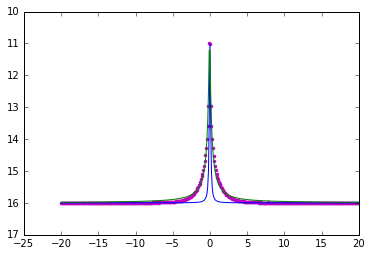

In [26]:
plt.plot(lightcurve[:,0]-peaks[0],lightcurve[:,1],'m.')
#plt.plot(lightcurve[:,0],bfx,'g-.')
plt.plot(lightcurve[:,0]-peaks[0],np.median(lightcurve[baseline,1]) -bell_curve(lightcurve[:,0]-peaks[0]
                                            , b_init_par[0], b_init_par[1],
                                             b_init_par[2], b_init_par[3]),'b-')

plt.plot(lightcurve[:,0]-peaks[0],bfx,'g-')
plt.gca().invert_yaxis()

In [27]:
g_chisq

0.9725545115233118

In [28]:
b_chisq

0.11057442716949695

In [29]:
calc_chisq(lightcurve,np.median(lightcurve[baseline,1]) -bell_curve(lightcurve[:,0]-peaks[0]
                                            , b_init_par[0], b_init_par[1],
                                             b_init_par[2], b_init_par[3]))

2.9174761281845587

In [30]:
PSPL_init_par = estimate_init_param(lightcurve, peaks[0], 'PSPL',
                                         baseline, event, it0)

(PSPLfit,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[event,0]-peaks[0],
                                                lightcurve[event,1],
                                                 p0=PSPL_init_par)
        
PSPLfx = PSPL(lightcurve[:,0]-peaks[0],PSPLfit[0],PSPLfit[1],PSPLfit[2],PSPLfit[3])
#PSPLfx = np.median(lightcurve[baseline,1]) - PSPLfx
        
PSPL_chisq = calc_chisq(lightcurve,PSPLfx)

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


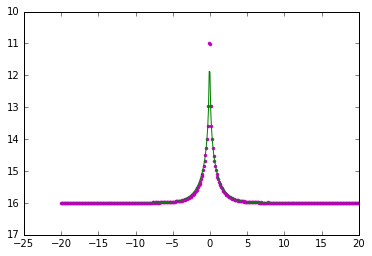

In [31]:
plt.plot(lightcurve[:,0]-peaks[0],lightcurve[:,1],'m.')
#plt.plot(lightcurve[:,0],bfx,'g-.')
# plt.plot(lightcurve[:,0]-peaks[0],PSPL(lightcurve[:,0]-peaks[0]
#                                             , PSPL_init_par[0], PSPL_init_par[1],
#                                              PSPL_init_par[2], PSPL_init_par[3]),'b-')

plt.plot(lightcurve[:,0]-peaks[0],PSPLfx,'g-')
plt.gca().invert_yaxis()

In [32]:
PSPL_chisq

0.14728440513682778

In [12]:
# Reading in one single lightcurve

f = '/ulwdc1_004_W149.txt'
t,m,e = np.loadtxt(temp+f,unpack=True)

df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': e})

In [434]:
# Testing the fit on an OGLE free-floating candidate with a large value of rho

f = 'data/OGLE_2012_BLG_1323/phot.dat'
t,m,e = np.loadtxt(f,unpack=True, usecols=(0,1,2))

df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': e})
df['del_m'] = df['magnitude']-np.median(df['magnitude'])

In [13]:
lightcurve = np.zeros((len(t),4))
lightcurve[:,0] = t
lightcurve[:,1] = m
lightcurve[:,2] = e
peaks = np.array([t[np.argmin(m)]])
(baseline, event, it0) = localize_event(lightcurve, peaks[0],50)



base = np.round(np.median(lightcurve[baseline,1]),4)
mag_peak = min(lightcurve[:,1][event])
A = 10 ** (0.4*(base - lightcurve[:,1]))
lightcurve[:,3] = A
A_max = 10 ** (0.4*(base - (m-e)))
A_min = 10 ** (0.4*(base - (m+e)))
Aerr = (A_max - A_min)/2

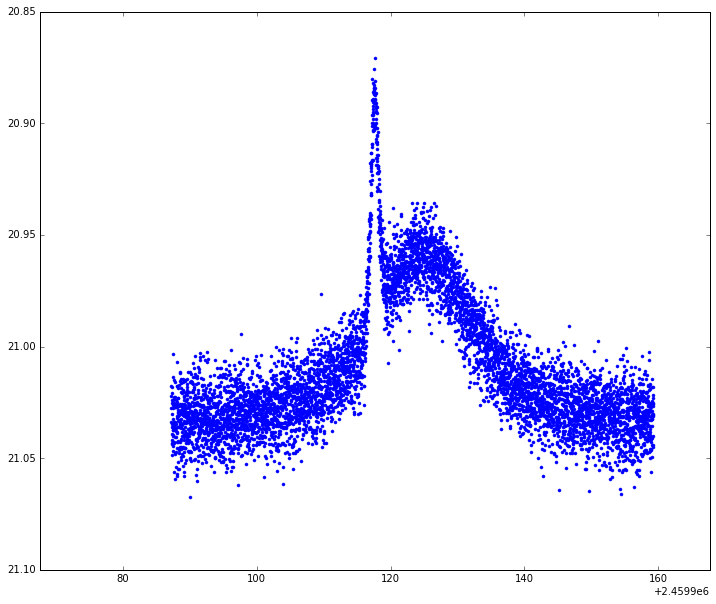

In [14]:
# Plotting one single light curve
dt = 50
plt.figure(1)
plt.plot(df['t'], df['magnitude'],'b.')
plt.gca().invert_yaxis()
#plt.axvline(1767.01716721)
plt.xlim(peaks[0]-dt, peaks[0]+dt)
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
#fig.savefig('Non-microlensing.png')

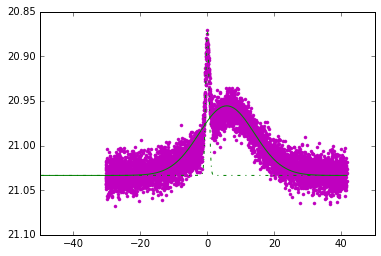

In [20]:
#Fitting Gaussian

(baseline, event, it0) = localize_event(lightcurve, peaks[0],50)
g_init_par = estimate_init_param(lightcurve, peaks[0], 'gaussian',
                                         baseline, event, it0)

(gfit,gcov) = optimize.curve_fit(gaussian,lightcurve[event,0]-peaks[0],
                                          -lightcurve[event,1]+np.median(lightcurve[baseline,1]),
                                         p0=g_init_par)

gfx = gaussian(lightcurve[:,0]-peaks[0],g_init_par[0],g_init_par[1],g_init_par[2])
gfx = np.median(lightcurve[baseline,1]) - gfx

gfx2 = gaussian(lightcurve[:,0]-peaks[0],gfit[0],gfit[1],gfit[2])
gfx2 = -gfx2+np.median(lightcurve[baseline,1])

plt.plot(lightcurve[:,0]-peaks[0],lightcurve[:,1],'m.')
plt.plot(lightcurve[:,0]-peaks[0],gfx,'g-.')
plt.plot(lightcurve[:,0]-peaks[0],gfx2,'g-')
plt.xlim(-50,50)
plt.gca().invert_yaxis()

[9.68568926 1.79289299 5.77631736 0.07495576]


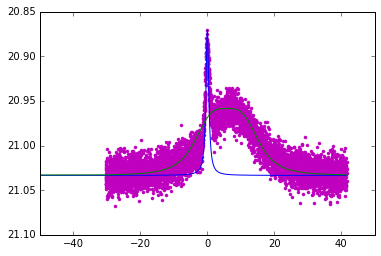

In [21]:
#Fitting bellcurve

b_init_par = estimate_init_param(lightcurve, peaks[0], 'bellcurve',
                                         baseline, event, it0)
b_init_par[1] = 1
#b_init_par = [3.0,1.0,0.0,4.0]

try: 
    (bfit,bcov) = optimize.curve_fit(bell_curve,lightcurve[:,0]-peaks[0],
                                                -lightcurve[:,1]+np.median(lightcurve[baseline,1]),
                                                 p0=b_init_par)
except RuntimeError:
        (baseline, event, it0) = localize_event(lightcurve, peaks[0],10)
        b_init_par = estimate_init_param(lightcurve, t0, 'bellcurve', baseline, event, it0)
        print b_init_par


        (bfit,bcov) = optimize.curve_fit(bell_curve,lightcurve[:,0]-t0,
                                                -lightcurve[:,1]+np.median(lightcurve[baseline,1]),
                                                 p0=b_init_par)

print bfit

bfx = bell_curve(lightcurve[:,0]-peaks[0],bfit[0],bfit[1],bfit[2],bfit[3])
bfx = np.median(lightcurve[baseline,1]) - bfx

plt.plot(lightcurve[:,0]-peaks[0],lightcurve[:,1],'m.')
plt.plot(lightcurve[:,0],bfx,'g-.')
plt.plot(lightcurve[:,0]-peaks[0],np.median(lightcurve[baseline,1]) -bell_curve(lightcurve[:,0]-peaks[0]
                                            , b_init_par[0], b_init_par[1],
                                             b_init_par[2], b_init_par[3]),'b-')

plt.plot(lightcurve[:,0]-peaks[0],bfx,'g-')
plt.xlim(-50,50)


plt.gca().invert_yaxis()

0.2351241857948511


0.23948527095557687

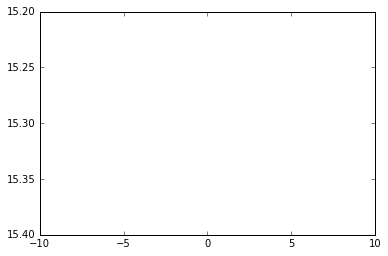

In [25]:
# Fitting bellcurve

PSPL_init_par_test = estimate_init_param(lightcurve, peaks[0], 'PSPL',
                                         baseline, event, it0)
#b_init_par = [3.0,1.0,0.0,4.0]


try: 
    (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peaks[0],lightcurve[:,3], p0=PSPL_init_par_test)
                                                 
except RuntimeError:
        (baseline, event, it0) = localize_event(lightcurve, peaks[0],10)
        PSPL_init_par_test = estimate_init_param(lightcurve, t0, 'PSPL', baseline, event, it0)

        (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-t0,
                                                lightcurve[:,3],
                                                 p0=b_init_par)




# ydata is magnification:
PSPLfx_test = PSPL(lightcurve[:,0]-peaks[0],PSPLfit_test[0],PSPLfit_test[1],PSPLfit_test[2])

# ydata is magnitude:
PSPLfx2_test = base*np.ones(len(PSPLfx_test)) + (-2.5 * np.log10(PSPLfx_test))


PSPL_chisq = calc_chisq(lightcurve,PSPLfx2_test)


guess_PSPL = PSPL(lightcurve[:,0]-peaks[0], PSPL_init_par_test[0], PSPL_init_par_test[1],
                        PSPL_init_par_test[2])

PSPLfx = PSPL(lightcurve[:,0]-peaks[0],PSPLfit_test[0],PSPLfit_test[1],PSPLfit_test[2])
PSPLfx2 = base*np.ones(len(PSPLfx)) + (-2.5 * np.log10(PSPLfx))





plt.plot(lightcurve[:,0]-peaks[0],lightcurve[:,1],'m.')
plt.plot(lightcurve[:,0]-peaks[0],PSPLfx2,'r-')
# plt.plot(lightcurve[:,0]-peaks[0],np.median(lightcurve[baseline,1]) -bell_curve(lightcurve[:,0]-peaks[0]
#                                             , b_init_par[0], b_init_par[1],
#                                              b_init_par[2], b_init_par[3]),'b-')

plt.plot(lightcurve[:,0]-peaks[0],bfx,'g-')
#plt.plot(lightcurve[:,0],bfx,'g-.')


plt.xlim(-10,10)
plt.ylim(15.20,15.4)

plt.gca().invert_yaxis()

#g_chisq = calc_chisq(lightcurve,gfx2)
b_chisq = calc_chisq(lightcurve,bfx)

print b_chisq

PSPL_chisq

In [466]:
PSPL_chisq

11811.010175169988

In [69]:
name = 'mag.dcnormffp_0_82_1921.det.lc.W149'
f = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'+str(name)
t,m,e = np.loadtxt(f,unpack=True)

print len(t)

F = 100**((np.max(m)-m)/5)

df = pd.DataFrame({'t': t, 'Flux_Ratio': F, 'magnitude': m, 'm_err': e})


38568


In [70]:
lightcurve = np.zeros((len(t),4))
lightcurve[:,0] = t
lightcurve[:,1] = m
lightcurve[:,2] = e
peak = t[np.argmin(m)]

(baseline, event, it0) = localize_event(lightcurve, peak,50)

base = np.round(np.median(lightcurve[baseline,1]),4)
mag_peak = min(lightcurve[:,1][event])
A = 10 ** (0.4*(base - lightcurve[:,1]))
lightcurve[:,3] = A
A_max = 10 ** (0.4*(base - (m-e)))
A_min = 10 ** (0.4*(base - (m+e)))
Aerr = (A_max - A_min)/2

In [71]:
peak-2458234

1797.4717879998498

In [72]:
b_init_par = estimate_init_param(lightcurve, peak, 'bellcurve',
                             baseline, event, it0)

In [73]:
(bfit,bcov) = optimize.curve_fit(bell_curve,lightcurve[:,0]-peak,
                                            -lightcurve[:,1]+np.median(lightcurve[baseline,1]),
                                             p0=b_init_par)

In [74]:
b_init_par[0]=1


In [75]:
bfx = np.median(lightcurve[baseline,1])-bell_curve(t-peak, *bfit )

0.71


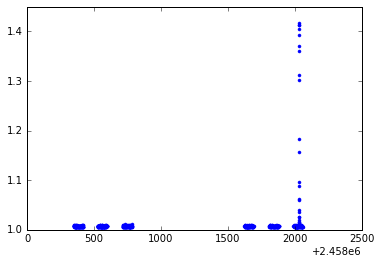

In [86]:
c = 0.80
if len(t[A>c*max(A)])>50:
    while len(t[A>c*max(A)])>50:
        c = c +0.01
else:
    while len(t[A>c*max(A)])<50:
        c = c -0.01
        
print c

plt.plot(t[A>c*max(A)], A[A>c*max(A)], 'b.')

In [87]:
len(t[A>0.71*max(A)])

714

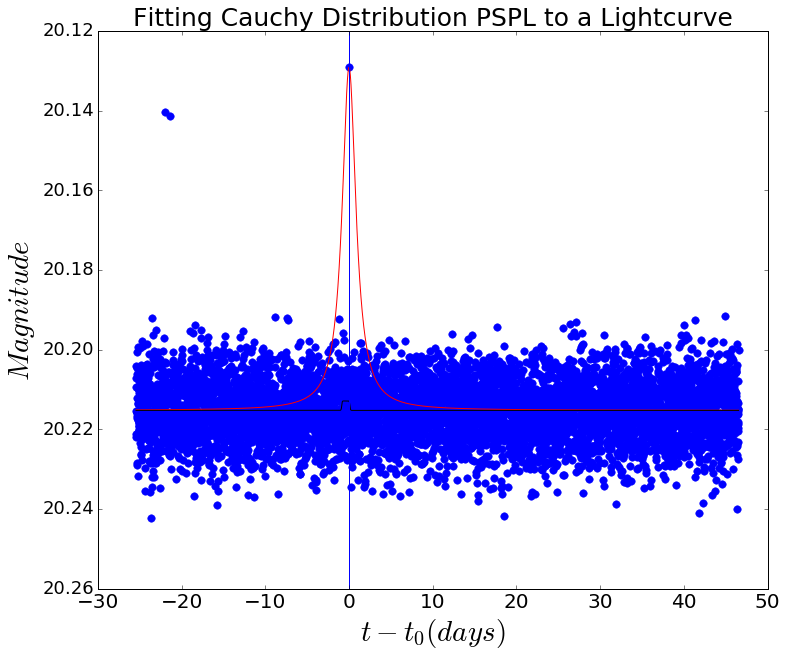

In [64]:
plt.figure()
plt.title('Fitting Cauchy Distribution PSPL to a Lightcurve', size=25)
plt.xlabel('$t - t_0 (days)$',size=29)
plt.ylabel('$Magnitude$',size=29)
plt.tick_params(axis='y',labelsize=18)
plt.tick_params(axis='x',labelsize=20)
plt.plot(t[event]-peak, m[event], 'b.', markersize=15)
#print param['t_eff=5']
plt.plot(t[event]-peak, np.median(lightcurve[baseline,1])-bell_curve(t[event]-peak, *b_init_par ), 'r-')
plt.plot(t[event]-peak, bfx[event], 'k-')
plt.axvline(b_init_par[2])


#plt.xlim(100,200)
plt.gca().invert_yaxis()
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
#fig.savefig('Trapezoid_FFP.png')

In [36]:
PSPL_init_par_test = estimate_init_param(lightcurve, peak, 'PSPL',
                                                baseline, event, it0)

tE_range = [0.01, 0.1, 1.0, 10.0]
trials = [[],[],[]]

for tE in tE_range:

    PSPL_init_par_test[2] = tE
    print PSPL_init_par_test

    try:
        (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peak, lightcurve[:,3], p0=PSPL_init_par_test)


    except RuntimeError:

        traceback.print_exc()

        (baseline, event, it0) = localize_event(lightcurve, peak,10)
        PSPL_init_par_test = estimate_init_param(lightcurve, peak, 'PSPL',
                                            baseline, event, it0)
        (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peak, lightcurve[:,3], p0=PSPL_init_par_test)

    # ydata is magnification:
    PSPLfx_test = PSPL(lightcurve[:,0]-peak,PSPLfit_test[0],PSPLfit_test[1],PSPLfit_test[2])
    
    # ydata is magnitude:
    PSPLfx2_test = base*np.ones(len(PSPLfx_test)) + (-2.5 * np.log10(PSPLfx_test))
    
    
    PSPL_chisq_test = calc_chisq(lightcurve,PSPLfx2_test)

    trials[0].append(PSPL_init_par_test)
    trials[1].append(PSPLfit_test)
    trials[2].append(PSPL_chisq_test)
print trials[2]

PSPL_chisq = np.min(trials[2])
PSPLfit = trials[1][np.argmin(PSPL_chisq_test)]
PSPL_init_par = trials[0][np.argmin(PSPL_chisq_test)]


guess_PSPL = PSPL(lightcurve[:,0]-peak, PSPL_init_par[0], PSPL_init_par[1],
                        PSPL_init_par[2])

PSPLfx = PSPL(lightcurve[:,0]-peak,PSPLfit[0],PSPLfit[1],PSPLfit[2])
PSPLfx2 = base*np.ones(len(PSPLfx)) + (-2.5 * np.log10(PSPLfx))




[0.0, 0.6906926984877383, 0.01]
[0.0, 0.6906926984877383, 0.1]
[0.0, 0.6906926984877383, 1.0]
[0.0, 0.6906926984877383, 10.0]
[0.019526256078794175, 0.019526256047019512, 0.01952625602489291, 0.019526256038978528]


In [37]:
bell_chisq = calc_chisq(lightcurve,bfx)

In [38]:
#ftype=='A'
print PSPL_chisq
print bell_chisq

0.01952625602489291
0.019540033063827678


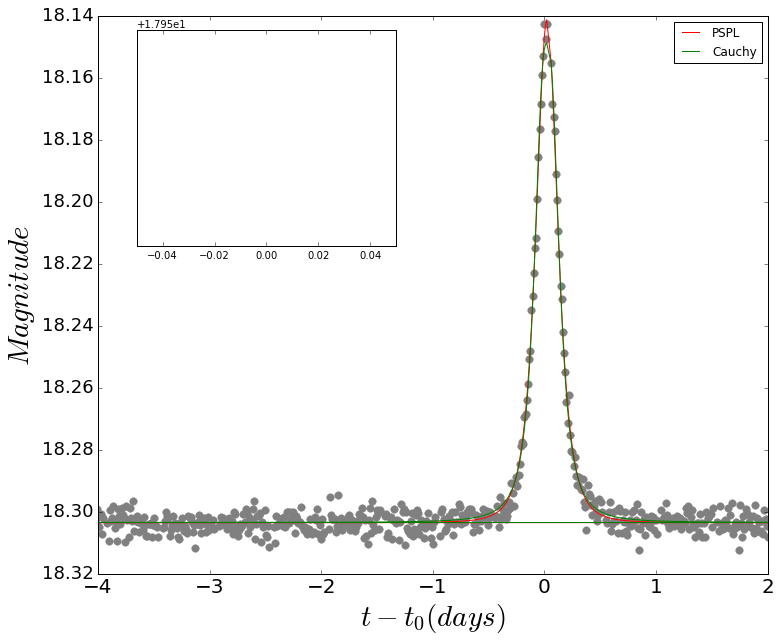

In [39]:
plt.figure()
ax = plt.gca()
#plt.title('Fitting Cauchy Distribution PSPL to a Lightcurve', size=25)
plt.xlabel('$t - t_0 (days)$',size=29)
plt.ylabel('$Magnitude$',size=29)
plt.tick_params(axis='y',labelsize=18)
plt.tick_params(axis='x',labelsize=20)
plt.plot(t[event]-peak, m[event], '.', color='gray', markersize=15)
#ax.set_yticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 22)
plt.plot(t[event]-peak, PSPLfx2[event], 'r-', linewidth=1, label = 'PSPL')
plt.plot(t[event]-peak, np.median(lightcurve[baseline,1])-bell_curve(t[event]-peak, *bfit ), 'g-', label = 'Cauchy')

plt.xlim(-4,2)
plt.gca().invert_yaxis()
plt.legend()

inset = plt.axes([0.17, 0.58, 0.3, 0.3])
inset.plot(t[event]-peak, m[event], '.', color='gray', markersize=15)
inset.plot(t[event]-peak, PSPLfx2[event], 'r-', linewidth=1)
inset.plot(t[event]-peak, bfx[event], 'g-', linewidth=1)
# inset.set_yticklabels(inset.get_yticklabels(), rotation = 90, fontsize = 22)
inset.axes.get_yaxis().set_ticks([18.05,18.0,17.95])
#mark_inset(ax, inset, loc1=1, loc2=4, fc="none", ec="0.5")


#x1, x2, y1, y2 = 

inset.set_xlim (-0.05,0.05)#(x1,x2)
inset.set_ylim (20.36,20.30)

#plt.axvline(PSPL_init_par[0])


fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
#fig.savefig('bellcurve_fit.png')

In [18]:
# Path to the larger dataset
home = os.path.expanduser("~")

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'#lc/'
direc = os.listdir(temp)

In [48]:
#Fitting Cauchy to Data Challenge light curves


direc.sort()
result = {'name':[], 't0_ml_bell':[], 'tE_ml_bell':[], 'b_ml_bell':[],'am_ml_bell':[],'guess_bell':[],
          'solution_bell':[], 'chisqr_bell':[], 't0_ml_PSPL':[], 'tE_ml_PSPL':[], 'u0_ml_PSPL':[],'guess_PSPL':[],
          'solution_PSPL':[], 'chisqr_PSPL':[], 'xdata': [], 'ydata': [], 'yerr': [], 'event': [],
         'chisqr_peak_bell':[], 'chisqr_peak_PSPL': [], 'peak_length':[]}
c = 0 

for f in tqdm(direc):
    #print f
    
    if  f.endswith('.W149') and f.endswith('.txt') and f.split('_')[2].startswith('W'): #f.startswith('mag.'):
        
        
#         print c
        c = c +1
        
        try:
            t,m,e = np.loadtxt(temp+str(f),unpack=True, usecols=(0,1, 2))

            lightcurve = np.zeros((len(t),5))
            lightcurve[:,0] = t
            lightcurve[:,1] = m
            lightcurve[:,2] = e
            peak = t[np.argmin(m)]

            (baseline, event, it0) = localize_event(lightcurve, peak,50)
            base = np.round(np.median(lightcurve[baseline,1]),4)
            mag_peak = min(lightcurve[:,1][event])
            A = 10 ** (0.4*(base - lightcurve[:,1]))
            lightcurve[:,3] = A
            
            A_max = 10 ** (0.4*(base - (m-e)))
            A_min = 10 ** (0.4*(base - (m+e)))
            Aerr = (A_max - A_min)/2
            lightcurve[:,4] = Aerr
            
            c2 = 0.80
            if len(t[A>c2*max(A)])>50:
                while len(t[A>c*max(A)])>50:
                    c2 = c2 +0.05
            else:
                while len(t[A>c2*max(A)])<50:
                    c2 = c2 -0.05

            #print c
            peak_length = len(t[A>c2*max(A)])


            
            
            PSPL_init_par_test = estimate_init_param(lightcurve, peak, 'PSPL',
                                                baseline, event, it0)

            tE_range = [0.01, 0.1, 1.0, 10.0]
            trials = [[],[],[]]
            
            for tE in tE_range:
                
                PSPL_init_par_test[2] = tE
                
                try:
                    (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peak, lightcurve[:,3], p0=PSPL_init_par_test)


                except RuntimeError:
                    
                    traceback.print_exc()

                    (baseline, event, it0) = localize_event(lightcurve, peak,10)
                    PSPL_init_par_test = estimate_init_param(lightcurve, peak, 'PSPL',
                                                        baseline, event, it0)
                    (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peak, lightcurve[:3], p0=PSPL_init_par_test)
                
                PSPLfx_test = PSPL(lightcurve[:,0]-peak,PSPLfit_test[0],PSPLfit_test[1],PSPLfit_test[2])
                PSPLfx2_test = base*np.ones(len(PSPLfx_test)) + (-2.5 * np.log10(PSPLfx_test))
                PSPL_chisq_test = calc_chisq(lightcurve,PSPLfx2_test)
                
                trials[0].append(PSPL_init_par_test)
                trials[1].append(PSPLfit_test)
                trials[2].append(PSPL_chisq_test)

            PSPL_chisq = np.min(trials[2])
            PSPLfit = trials[1][np.argmin(PSPL_chisq_test)]
            PSPL_init_par = trials[0][np.argmin(PSPL_chisq_test)]
            #print PSPL_init_par


            guess_PSPL = PSPL(lightcurve[:,0]-peak, PSPL_init_par[0], PSPL_init_par[1],PSPL_init_par[2])
            
            # SOlution in magnification
            PSPLfx = PSPL(lightcurve[:,0]-peak,PSPLfit[0],PSPLfit[1],PSPLfit[2])
            # Solution in magnitude
            PSPLfx = base*np.ones(len(PSPLfx)) + (-2.5 * np.log10(PSPLfx))
            
            # Peak solution in magnification
            peak_PSPL = PSPL(lightcurve[:,0][A>c2*max(A)]-peak,PSPLfit[0],PSPLfit[1],PSPLfit[2])
            # Peak solution in magnitude
            peak_PSPL = base*np.ones(len(peak_PSPL)) + (-2.5 * np.log10(peak_PSPL))
            
            
            chisqr_peak_PSPL = calc_chisq(lightcurve[A>c2*max(A)],peak_PSPL)


                                                                          
            
            # Fitting Bell vurve
            
            b_init_par = estimate_init_param(lightcurve, peak, 'bellcurve',
                                         baseline, event, it0)
            b_init_par[1] = 1
            
            try: 
                (bfit,bcov) = optimize.curve_fit(bell_curve,lightcurve[:,0]-peak,
                                                            -lightcurve[:,1]+np.median(lightcurve[baseline,1]),
                                                             p0=b_init_par)
            except RuntimeError:
                
                traceback.print_exc()
                (baseline, event, it0) = localize_event(lightcurve, peak,10)
                b_init_par = estimate_init_param(lightcurve, peak, 'bellcurve', baseline, event, it0)
                (bfit,bcov) = optimize.curve_fit(bell_curve,lightcurve[:,0]-peak,
                                                        -lightcurve[:,1]+np.median(lightcurve[baseline,1]),
                                                         p0=b_init_par)

            guess_Bell = np.median(lightcurve[baseline,1]) -bell_curve(lightcurve[:,0]-peaks[0]
                                            , b_init_par[0], b_init_par[1],
                                             b_init_par[2], b_init_par[3])

            bfx = bell_curve(lightcurve[:,0]-peak,bfit[0],bfit[1],bfit[2],bfit[3])
            bfx = np.median(lightcurve[baseline,1]) - bfx

            bell_chisq = calc_chisq(lightcurve,bfx)
            chisqr_peak_bell = calc_chisq(lightcurve[A>c2*max(A)],bell_curve(lightcurve[:,0][A>c2*max(A)]-peak,bfit[0],bfit[1],bfit[2],bfit[3]))
            
            result['name'].append(f)
            result['t0_ml_bell'].append(bfit[2]+peak)
            result['tE_ml_bell'].append(bfit[0])
            result['b_ml_bell'].append(bfit[1])
            result['am_ml_bell'].append(bfit[3])
            result['guess_bell'].append(guess_Bell)
            result['solution_bell'].append(bfx)
            result['chisqr_bell'].append(bell_chisq)
            result['chisqr_peak_bell'].append(chisqr_peak_bell)
            result['t0_ml_PSPL'].append(PSPLfit[0]+peak)
            result['tE_ml_PSPL'].append(PSPLfit[2])
            result['u0_ml_PSPL'].append(PSPLfit[1])
#            result['guess_PSPL'].append(guess_PSPL)
            result['solution_PSPL'].append(PSPLfx)
            result['chisqr_PSPL'].append(PSPL_chisq)
            result['chisqr_peak_PSPL'].append(chisqr_peak_PSPL)
            result['peak_length'].append(peak_length)
            result['event'].append(event)
            result['xdata'].append(t)
            result['ydata'].append(m)
            result['yerr'].append(e)
            
            
        except (RuntimeError, TypeError, NameError, ValueError):
            traceback.print_exc()
            pass
#     if c == 4:
#         break

print 'done'









100%|██████████| 9948/9948 [00:00<00:00, 1065090.90it/s]

done


In [20]:
info1 = pd.read_csv('ombin.CSV')
info2 = pd.read_csv('omcassan.CSV')
info3 = pd.read_csv('dccv.CSV')
info4 = pd.read_csv('dcnormffp.CSV')

In [21]:
frames = [info1, info2, info3, info4]

info = pd.concat(frames)

In [22]:
info['t0_ml_bell'] = np.zeros(len(info))
info['tE_ml_bell'] = np.zeros(len(info))
info['am_ml_bell'] = np.zeros(len(info))
info['b_ml_bell'] = np.zeros(len(info))
info['t0_ml_PSPL'] = np.zeros(len(info))
info['tE_ml_PSPL'] = np.zeros(len(info))
info['u0_ml_PSPL'] = np.zeros(len(info))
info['chisqr_bell'] = np.zeros(len(info))
info['chisqr_PSPL'] = np.zeros(len(info))
info['chisqr_peak_bell'] = np.zeros(len(info))
info['chisqr_peak_PSPL'] = np.zeros(len(info))
info['peak_length'] = np.zeros(len(info))

In [23]:
info = info.rename(columns={"index": "name"})

In [24]:
for i in range(len(result['name'])):

    if result['name'][i].split('.lc')[0].endswith('all'): 
        result['name'][i] = result['name'][i].split('all')[0]+'det'+result['name'][i].split('all')[1]

In [25]:

for i in tqdm(range(len(result['name']))):
     
    
    info.loc[info.name == result['name'][i], 'tE_ml_bell'] = result['tE_ml_bell'][i]
    info.loc[info.name == result['name'][i], 't0_ml_bell'] = result['t0_ml_bell'][i]
    info.loc[info.name == result['name'][i], 'am_ml_bell'] = result['am_ml_bell'][i]
    info.loc[info.name == result['name'][i], 'b_ml_bell'] = result['b_ml_bell'][i]
    info.loc[info.name == result['name'][i], 'tE_ml_PSPL'] = result['tE_ml_PSPL'][i]
    info.loc[info.name == result['name'][i], 't0_ml_PSPL'] = result['t0_ml_PSPL'][i]
    info.loc[info.name == result['name'][i], 'u0_ml_PSPL'] = result['u0_ml_PSPL'][i]
    info.loc[info.name == result['name'][i], 'chisqr_bell'] = result['chisqr_bell'][i]
    info.loc[info.name == result['name'][i], 'chisqr_PSPL'] = result['chisqr_PSPL'][i]
    info.loc[info.name == result['name'][i], 'chisqr_peak_bell'] = result['chisqr_peak_bell'][i]
    info.loc[info.name == result['name'][i], 'chisqr_peak_PSPL'] = result['chisqr_peak_PSPL'][i]
    info.loc[info.name == result['name'][i], 'peak_length'] = result['peak_length'][i]
    
    if not result['name'][i] in info.name.values:
        print result['name'][i]

 77%|███████▋  | 3111/4046 [02:12<00:39, 23.50it/s]

mag.omcassan_0_100_1197.det.lc.W149
mag.omcassan_0_100_3114.det.lc.W149
mag.omcassan_0_100_66.det.lc.W149


 77%|███████▋  | 3120/4046 [02:12<00:39, 23.50it/s]

mag.omcassan_0_10_1228.det.lc.W149


 77%|███████▋  | 3135/4046 [02:13<00:38, 23.50it/s]

mag.omcassan_0_21_2040.det.lc.W149
mag.omcassan_0_21_414.det.lc.W149
mag.omcassan_0_22_3213.det.lc.W149


 78%|███████▊  | 3150/4046 [02:14<00:38, 23.51it/s]

mag.omcassan_0_34_1491.det.lc.W149
mag.omcassan_0_35_2018.det.lc.W149


 78%|███████▊  | 3159/4046 [02:14<00:37, 23.51it/s]

mag.omcassan_0_44_669.det.lc.W149
mag.omcassan_0_46_400.det.lc.W149


 78%|███████▊  | 3165/4046 [02:14<00:37, 23.51it/s]

mag.omcassan_0_48_1719.det.lc.W149
mag.omcassan_0_49_1633.det.lc.W149
mag.omcassan_0_58_1019.det.lc.W149


 78%|███████▊  | 3174/4046 [02:15<00:37, 23.51it/s]

mag.omcassan_0_59_1633.det.lc.W149
mag.omcassan_0_59_2013.det.lc.W149
mag.omcassan_0_61_1201.det.lc.W149


 79%|███████▊  | 3180/4046 [02:15<00:36, 23.51it/s]

mag.omcassan_0_61_384.det.lc.W149
mag.omcassan_0_61_681.det.lc.W149
mag.omcassan_0_63_316.det.lc.W149
mag.omcassan_0_6_1191.det.lc.W149


 79%|███████▊  | 3186/4046 [02:15<00:36, 23.51it/s]

mag.omcassan_0_71_259.det.lc.W149


 79%|███████▉  | 3201/4046 [02:16<00:35, 23.51it/s]

mag.omcassan_0_7_534.det.lc.W149
mag.omcassan_0_83_241.det.lc.W149


 79%|███████▉  | 3207/4046 [02:16<00:35, 23.51it/s]

mag.omcassan_0_86_2143.det.lc.W149
mag.omcassan_0_86_2152.det.lc.W149
mag.omcassan_0_87_1718.det.lc.W149
mag.omcassan_0_87_2127.det.lc.W149


 79%|███████▉  | 3213/4046 [02:16<00:35, 23.51it/s]

mag.omcassan_0_88_2050.det.lc.W149
mag.omcassan_0_89_114.det.lc.W149


 80%|███████▉  | 3219/4046 [02:16<00:35, 23.51it/s]

mag.omcassan_0_97_1005.det.lc.W149
mag.omcassan_0_97_964.det.lc.W149
mag.omcassan_0_98_1412.det.lc.W149
mag.omcassan_0_99_1601.det.lc.W149


 80%|███████▉  | 3231/4046 [02:17<00:34, 23.51it/s]

mag.omcassan_10_18_463.det.lc.W149


 80%|████████  | 3240/4046 [02:17<00:34, 23.51it/s]

mag.omcassan_10_44_787.det.lc.W149
mag.omcassan_10_47_126.det.lc.W149
mag.omcassan_10_50_253.det.lc.W149
mag.omcassan_10_5_594.det.lc.W149


 80%|████████  | 3246/4046 [02:18<00:34, 23.51it/s]

mag.omcassan_10_6_423.det.lc.W149
mag.omcassan_10_72_1307.det.lc.W149
mag.omcassan_10_73_847.det.lc.W149


 80%|████████  | 3255/4046 [02:18<00:33, 23.51it/s]

mag.omcassan_10_89_385.det.lc.W149
mag.omcassan_10_98_148.det.lc.W149


 81%|████████  | 3267/4046 [02:18<00:33, 23.51it/s]

mag.omcassan_1_110_551.det.lc.W149
mag.omcassan_1_111_474.det.lc.W149
mag.omcassan_1_112_1070.det.lc.W149


 81%|████████  | 3273/4046 [02:19<00:32, 23.51it/s]

mag.omcassan_1_112_65.det.lc.W149
mag.omcassan_1_113_1809.det.lc.W149


 81%|████████  | 3282/4046 [02:19<00:32, 23.51it/s]

mag.omcassan_1_11_182.det.lc.W149
mag.omcassan_1_18_674.det.lc.W149
mag.omcassan_1_20_288.det.lc.W149


 81%|████████▏ | 3288/4046 [02:19<00:32, 23.51it/s]

mag.omcassan_1_20_979.det.lc.W149
mag.omcassan_1_23_1262.det.lc.W149
mag.omcassan_1_23_1397.det.lc.W149


 81%|████████▏ | 3294/4046 [02:20<00:31, 23.51it/s]

mag.omcassan_1_23_990.det.lc.W149
mag.omcassan_1_31_529.det.lc.W149


 82%|████████▏ | 3303/4046 [02:20<00:31, 23.51it/s]

mag.omcassan_1_48_1401.det.lc.W149


 82%|████████▏ | 3309/4046 [02:20<00:31, 23.51it/s]

mag.omcassan_1_57_2109.det.lc.W149


 82%|████████▏ | 3318/4046 [02:21<00:30, 23.51it/s]

mag.omcassan_1_5_2403.det.lc.W149
mag.omcassan_1_5_2609.det.lc.W149
mag.omcassan_1_60_992.det.lc.W149
mag.omcassan_1_62_1260.det.lc.W149


 82%|████████▏ | 3321/4046 [02:21<00:30, 23.51it/s]

mag.omcassan_1_63_1559.det.lc.W149
mag.omcassan_1_70_1516.det.lc.W149


 82%|████████▏ | 3330/4046 [02:21<00:30, 23.51it/s]

mag.omcassan_1_73_1372.det.lc.W149


 82%|████████▏ | 3336/4046 [02:21<00:30, 23.51it/s]

mag.omcassan_1_75_1206.det.lc.W149
mag.omcassan_1_75_250.det.lc.W149


 83%|████████▎ | 3345/4046 [02:22<00:29, 23.51it/s]

mag.omcassan_1_84_1418.det.lc.W149
mag.omcassan_1_89_1625.det.lc.W149
mag.omcassan_1_89_565.det.lc.W149


 83%|████████▎ | 3354/4046 [02:22<00:29, 23.51it/s]

mag.omcassan_1_98_479.det.lc.W149


 83%|████████▎ | 3369/4046 [02:23<00:28, 23.51it/s]

mag.omcassan_2_10_214.det.lc.W149
mag.omcassan_2_110_1013.det.lc.W149
mag.omcassan_2_110_1407.det.lc.W149
mag.omcassan_2_110_2700.det.lc.W149


 83%|████████▎ | 3375/4046 [02:23<00:28, 23.51it/s]

mag.omcassan_2_112_3277.det.lc.W149
mag.omcassan_2_115_1010.det.lc.W149


 84%|████████▎ | 3384/4046 [02:23<00:28, 23.51it/s]

mag.omcassan_2_20_253.det.lc.W149


 84%|████████▍ | 3390/4046 [02:24<00:27, 23.51it/s]

mag.omcassan_2_24_1036.det.lc.W149
mag.omcassan_2_31_1443.det.lc.W149
mag.omcassan_2_31_37.det.lc.W149
mag.omcassan_2_31_832.det.lc.W149


 84%|████████▍ | 3393/4046 [02:24<00:27, 23.51it/s]

mag.omcassan_2_33_54.det.lc.W149


 84%|████████▍ | 3402/4046 [02:24<00:27, 23.51it/s]

mag.omcassan_2_50_216.det.lc.W149
mag.omcassan_2_50_726.det.lc.W149


 84%|████████▍ | 3408/4046 [02:24<00:27, 23.51it/s]

mag.omcassan_2_58_1579.det.lc.W149


 85%|████████▍ | 3426/4046 [02:25<00:26, 23.51it/s]

mag.omcassan_2_76_219.det.lc.W149


 85%|████████▍ | 3438/4046 [02:26<00:25, 23.51it/s]

mag.omcassan_2_87_970.det.lc.W149
mag.omcassan_2_88_1615.det.lc.W149
mag.omcassan_2_96_1919.det.lc.W149


 85%|████████▌ | 3447/4046 [02:26<00:25, 23.51it/s]

mag.omcassan_2_98_1355.det.lc.W149
mag.omcassan_3_101_1518.det.lc.W149


 85%|████████▌ | 3459/4046 [02:27<00:24, 23.51it/s]

mag.omcassan_3_10_404.det.lc.W149
mag.omcassan_3_10_486.det.lc.W149
mag.omcassan_3_10_628.det.lc.W149
mag.omcassan_3_110_1304.det.lc.W149


 86%|████████▌ | 3474/4046 [02:27<00:24, 23.51it/s]

mag.omcassan_3_11_2077.det.lc.W149
mag.omcassan_3_11_3148.det.lc.W149
mag.omcassan_3_18_3023.det.lc.W149


 86%|████████▌ | 3480/4046 [02:28<00:24, 23.51it/s]

mag.omcassan_3_20_1560.det.lc.W149
mag.omcassan_3_20_1641.det.lc.W149


 86%|████████▌ | 3486/4046 [02:28<00:23, 23.51it/s]

mag.omcassan_3_21_3178.det.lc.W149


 86%|████████▋ | 3492/4046 [02:28<00:23, 23.51it/s]

mag.omcassan_3_24_1912.det.lc.W149
mag.omcassan_3_31_677.det.lc.W149


 86%|████████▋ | 3495/4046 [02:28<00:23, 23.51it/s]

mag.omcassan_3_33_976.det.lc.W149


 87%|████████▋ | 3501/4046 [02:28<00:23, 23.51it/s]

mag.omcassan_3_49_397.det.lc.W149


 87%|████████▋ | 3510/4046 [02:29<00:22, 23.51it/s]

mag.omcassan_3_60_1155.det.lc.W149
mag.omcassan_3_60_610.det.lc.W149
mag.omcassan_3_61_1090.det.lc.W149


 87%|████████▋ | 3519/4046 [02:29<00:22, 23.51it/s]

mag.omcassan_3_70_2948.det.lc.W149


 87%|████████▋ | 3525/4046 [02:29<00:22, 23.51it/s]

mag.omcassan_3_72_1843.det.lc.W149
mag.omcassan_3_72_2269.det.lc.W149


 87%|████████▋ | 3534/4046 [02:30<00:21, 23.51it/s]

mag.omcassan_3_75_2250.det.lc.W149
mag.omcassan_3_76_472.det.lc.W149
mag.omcassan_3_83_382.det.lc.W149


 87%|████████▋ | 3537/4046 [02:30<00:21, 23.51it/s]

mag.omcassan_3_84_119.det.lc.W149


 88%|████████▊ | 3546/4046 [02:30<00:21, 23.51it/s]

mag.omcassan_3_86_862.det.lc.W149
mag.omcassan_3_87_49.det.lc.W149


 88%|████████▊ | 3552/4046 [02:31<00:21, 23.51it/s]

mag.omcassan_3_89_51.det.lc.W149
mag.omcassan_3_89_57.det.lc.W149
mag.omcassan_3_96_1862.det.lc.W149


 88%|████████▊ | 3558/4046 [02:31<00:20, 23.51it/s]

mag.omcassan_3_97_694.det.lc.W149
mag.omcassan_3_9_165.det.lc.W149


 88%|████████▊ | 3567/4046 [02:31<00:20, 23.51it/s]

mag.omcassan_4_100_282.det.lc.W149
mag.omcassan_4_100_393.det.lc.W149


 88%|████████▊ | 3573/4046 [02:31<00:20, 23.51it/s]

mag.omcassan_4_102_2853.det.lc.W149
mag.omcassan_4_102_369.det.lc.W149


 88%|████████▊ | 3579/4046 [02:32<00:19, 23.51it/s]

mag.omcassan_4_111_506.det.lc.W149
mag.omcassan_4_112_1245.det.lc.W149
mag.omcassan_4_112_585.det.lc.W149


 89%|████████▉ | 3591/4046 [02:32<00:19, 23.51it/s]

mag.omcassan_4_115_3069.det.lc.W149
mag.omcassan_4_115_510.det.lc.W149


 89%|████████▉ | 3594/4046 [02:32<00:19, 23.51it/s]

mag.omcassan_4_18_1719.det.lc.W149


 89%|████████▉ | 3603/4046 [02:33<00:18, 23.51it/s]

mag.omcassan_4_20_1994.det.lc.W149


 89%|████████▉ | 3606/4046 [02:33<00:18, 23.51it/s]

mag.omcassan_4_22_1056.det.lc.W149
mag.omcassan_4_22_117.det.lc.W149


 89%|████████▉ | 3615/4046 [02:33<00:18, 23.51it/s]

mag.omcassan_4_32_2432.det.lc.W149
mag.omcassan_4_32_2978.det.lc.W149
mag.omcassan_4_34_1702.det.lc.W149


 89%|████████▉ | 3621/4046 [02:34<00:18, 23.51it/s]

mag.omcassan_4_35_120.det.lc.W149
mag.omcassan_4_36_1502.det.lc.W149


 90%|████████▉ | 3627/4046 [02:34<00:17, 23.51it/s]

mag.omcassan_4_45_2664.det.lc.W149
mag.omcassan_4_46_1589.det.lc.W149
mag.omcassan_4_48_1128.det.lc.W149


 90%|████████▉ | 3633/4046 [02:34<00:17, 23.51it/s]

mag.omcassan_4_48_41.det.lc.W149
mag.omcassan_4_49_18.det.lc.W149
mag.omcassan_4_50_713.det.lc.W149


 90%|████████▉ | 3636/4046 [02:34<00:17, 23.51it/s]

mag.omcassan_4_57_3017.det.lc.W149
mag.omcassan_4_58_965.det.lc.W149


 90%|█████████ | 3645/4046 [02:35<00:17, 23.51it/s]

mag.omcassan_4_59_1960.det.lc.W149
mag.omcassan_4_5_2136.det.lc.W149


 90%|█████████ | 3651/4046 [02:35<00:16, 23.51it/s]

mag.omcassan_4_5_2998.det.lc.W149
mag.omcassan_4_5_3035.det.lc.W149


 90%|█████████ | 3654/4046 [02:35<00:16, 23.51it/s]

mag.omcassan_4_61_1408.det.lc.W149
mag.omcassan_4_61_1697.det.lc.W149
mag.omcassan_4_61_418.det.lc.W149


 91%|█████████ | 3663/4046 [02:35<00:16, 23.51it/s]

mag.omcassan_4_71_388.det.lc.W149


 91%|█████████ | 3672/4046 [02:36<00:15, 23.51it/s]

mag.omcassan_4_76_1183.det.lc.W149
mag.omcassan_4_7_1120.det.lc.W149
mag.omcassan_4_7_1389.det.lc.W149
mag.omcassan_4_7_2334.det.lc.W149


 91%|█████████ | 3678/4046 [02:36<00:15, 23.51it/s]

mag.omcassan_4_85_882.det.lc.W149
mag.omcassan_4_86_3148.det.lc.W149
mag.omcassan_4_88_147.det.lc.W149


 91%|█████████ | 3684/4046 [02:36<00:15, 23.51it/s]

mag.omcassan_4_89_26.det.lc.W149


 91%|█████████▏| 3693/4046 [02:37<00:15, 23.51it/s]

mag.omcassan_4_98_2078.det.lc.W149
mag.omcassan_4_99_747.det.lc.W149


 92%|█████████▏| 3705/4046 [02:37<00:14, 23.51it/s]

mag.omcassan_5_109_1444.det.lc.W149


 92%|█████████▏| 3717/4046 [02:38<00:13, 23.51it/s]

mag.omcassan_5_115_1345.det.lc.W149


 92%|█████████▏| 3729/4046 [02:38<00:13, 23.52it/s]

mag.omcassan_5_20_827.det.lc.W149


 92%|█████████▏| 3738/4046 [02:38<00:13, 23.52it/s]

mag.omcassan_5_22_702.det.lc.W149
mag.omcassan_5_24_2829.det.lc.W149
mag.omcassan_5_31_1788.det.lc.W149


 92%|█████████▏| 3741/4046 [02:39<00:12, 23.52it/s]

mag.omcassan_5_32_2780.det.lc.W149
mag.omcassan_5_32_901.det.lc.W149
mag.omcassan_5_33_1030.det.lc.W149


 93%|█████████▎| 3747/4046 [02:39<00:12, 23.52it/s]

mag.omcassan_5_33_2063.det.lc.W149
mag.omcassan_5_33_494.det.lc.W149
mag.omcassan_5_35_1368.det.lc.W149
mag.omcassan_5_36_594.det.lc.W149


 93%|█████████▎| 3759/4046 [02:39<00:12, 23.52it/s]

mag.omcassan_5_48_2673.det.lc.W149


 93%|█████████▎| 3768/4046 [02:40<00:11, 23.52it/s]

mag.omcassan_5_58_943.det.lc.W149
mag.omcassan_5_59_364.det.lc.W149
mag.omcassan_5_59_423.det.lc.W149
mag.omcassan_5_59_58.det.lc.W149


 93%|█████████▎| 3777/4046 [02:40<00:11, 23.52it/s]

mag.omcassan_5_63_1267.det.lc.W149


 93%|█████████▎| 3783/4046 [02:40<00:11, 23.52it/s]

mag.omcassan_5_70_1893.det.lc.W149
mag.omcassan_5_72_771.det.lc.W149


 94%|█████████▎| 3789/4046 [02:41<00:10, 23.52it/s]

mag.omcassan_5_73_1293.det.lc.W149


 94%|█████████▍| 3798/4046 [02:41<00:10, 23.52it/s]

mag.omcassan_5_96_2508.det.lc.W149
mag.omcassan_5_98_680.det.lc.W149


 94%|█████████▍| 3807/4046 [02:41<00:10, 23.52it/s]

mag.omcassan_6_100_449.det.lc.W149
mag.omcassan_6_101_674.det.lc.W149
mag.omcassan_6_109_1439.det.lc.W149


 94%|█████████▍| 3813/4046 [02:42<00:09, 23.52it/s]

mag.omcassan_6_110_1017.det.lc.W149
mag.omcassan_6_113_876.det.lc.W149


 94%|█████████▍| 3819/4046 [02:42<00:09, 23.52it/s]

mag.omcassan_6_18_778.det.lc.W149
mag.omcassan_6_19_780.det.lc.W149
mag.omcassan_6_21_1422.det.lc.W149


 95%|█████████▍| 3825/4046 [02:42<00:09, 23.52it/s]

mag.omcassan_6_22_143.det.lc.W149
mag.omcassan_6_31_1211.det.lc.W149
mag.omcassan_6_32_1161.det.lc.W149


 95%|█████████▍| 3834/4046 [02:43<00:09, 23.52it/s]

mag.omcassan_6_37_515.det.lc.W149
mag.omcassan_6_44_718.det.lc.W149


 95%|█████████▍| 3840/4046 [02:43<00:08, 23.52it/s]

mag.omcassan_6_48_138.det.lc.W149


 95%|█████████▌| 3846/4046 [02:43<00:08, 23.52it/s]

mag.omcassan_6_61_1145.det.lc.W149
mag.omcassan_6_63_275.det.lc.W149
mag.omcassan_6_6_1121.det.lc.W149
mag.omcassan_6_6_1314.det.lc.W149


 95%|█████████▌| 3855/4046 [02:43<00:08, 23.52it/s]

mag.omcassan_6_71_1009.det.lc.W149
mag.omcassan_6_73_1158.det.lc.W149
mag.omcassan_6_74_46.det.lc.W149
mag.omcassan_6_74_69.det.lc.W149


 95%|█████████▌| 3858/4046 [02:44<00:07, 23.52it/s]

mag.omcassan_6_83_728.det.lc.W149


 96%|█████████▌| 3876/4046 [02:44<00:07, 23.52it/s]

mag.omcassan_7_109_476.det.lc.W149
mag.omcassan_7_10_1028.det.lc.W149
mag.omcassan_7_110_397.det.lc.W149


 96%|█████████▌| 3888/4046 [02:45<00:06, 23.52it/s]

mag.omcassan_7_18_1025.det.lc.W149
mag.omcassan_7_18_1395.det.lc.W149


 96%|█████████▌| 3891/4046 [02:45<00:06, 23.52it/s]

mag.omcassan_7_19_321.det.lc.W149


 97%|█████████▋| 3909/4046 [02:46<00:05, 23.52it/s]

mag.omcassan_7_35_1480.det.lc.W149
mag.omcassan_7_35_1849.det.lc.W149


 97%|█████████▋| 3915/4046 [02:46<00:05, 23.52it/s]

mag.omcassan_7_45_1506.det.lc.W149
mag.omcassan_7_46_132.det.lc.W149
mag.omcassan_7_47_674.det.lc.W149


 97%|█████████▋| 3927/4046 [02:46<00:05, 23.52it/s]

mag.omcassan_7_61_349.det.lc.W149
mag.omcassan_7_6_217.det.lc.W149


 97%|█████████▋| 3933/4046 [02:47<00:04, 23.52it/s]

mag.omcassan_7_70_805.det.lc.W149
mag.omcassan_7_76_1006.det.lc.W149


 97%|█████████▋| 3939/4046 [02:47<00:04, 23.52it/s]

mag.omcassan_7_86_1057.det.lc.W149


 98%|█████████▊| 3945/4046 [02:47<00:04, 23.52it/s]

mag.omcassan_8_111_1331.det.lc.W149
mag.omcassan_8_112_591.det.lc.W149
mag.omcassan_8_11_1083.det.lc.W149


 98%|█████████▊| 3951/4046 [02:47<00:04, 23.52it/s]

mag.omcassan_8_11_432.det.lc.W149
mag.omcassan_8_20_529.det.lc.W149


 98%|█████████▊| 3957/4046 [02:48<00:03, 23.52it/s]

mag.omcassan_8_23_988.det.lc.W149
mag.omcassan_8_24_844.det.lc.W149


 98%|█████████▊| 3963/4046 [02:48<00:03, 23.52it/s]

mag.omcassan_8_36_245.det.lc.W149


 98%|█████████▊| 3972/4046 [02:48<00:03, 23.52it/s]

mag.omcassan_8_50_222.det.lc.W149


 98%|█████████▊| 3975/4046 [02:48<00:03, 23.52it/s]

mag.omcassan_8_61_714.det.lc.W149


 98%|█████████▊| 3981/4046 [02:49<00:02, 23.52it/s]

mag.omcassan_8_75_1283.det.lc.W149


 99%|█████████▊| 3987/4046 [02:49<00:02, 23.52it/s]

mag.omcassan_8_83_234.det.lc.W149
mag.omcassan_8_8_1306.det.lc.W149
mag.omcassan_8_96_617.det.lc.W149


 99%|█████████▉| 3996/4046 [02:49<00:02, 23.52it/s]

mag.omcassan_9_100_1029.det.lc.W149
mag.omcassan_9_109_347.det.lc.W149
mag.omcassan_9_110_116.det.lc.W149


 99%|█████████▉| 4002/4046 [02:50<00:01, 23.52it/s]

mag.omcassan_9_112_145.det.lc.W149


 99%|█████████▉| 4011/4046 [02:50<00:01, 23.53it/s]

mag.omcassan_9_24_504.det.lc.W149
mag.omcassan_9_24_563.det.lc.W149
mag.omcassan_9_31_743.det.lc.W149


 99%|█████████▉| 4020/4046 [02:50<00:01, 23.53it/s]

mag.omcassan_9_46_840.det.lc.W149


100%|█████████▉| 4029/4046 [02:51<00:00, 23.52it/s]

mag.omcassan_9_59_130.det.lc.W149
mag.omcassan_9_5_426.det.lc.W149
mag.omcassan_9_60_557.det.lc.W149


100%|██████████| 4046/4046 [02:52<00:00, 23.52it/s]

mag.omcassan_9_89_499.det.lc.W149
mag.omcassan_9_99_932.det.lc.W149


In [26]:
info = info.reset_index()

In [27]:
info['type'] = np.zeros(len(info))

for i in tqdm(range(len(info))):
    
    if info['name'][i].split('mag')[1].startswith('.ombin'):
        
        info.set_value(i, 'type', 1)
        
    if info['name'][i].split('mag')[1].startswith('.dccv'):
        
        info.set_value(i, 'type', 0)
        
        
    if info['name'][i].split('mag')[1].startswith('.dcnormffp'):
        
        info.set_value(i, 'type', 3)
        
    if info['name'][i].split('mag')[1].startswith('.omcassan'):
        
        info.set_value(i, 'type', 2)

 24%|██▍       | 1151/4770 [00:00<00:00, 11495.40it/s]/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
100%|██████████| 4770/4770 [00:00<00:00, 12181.20it/s]


In [28]:
info['delta_chisqr'] = info.chisqr_PSPL - info.chisqr_bell

In [29]:
info['delta_chisqr_peak'] = info.chisqr_peak_PSPL - info.chisqr_peak_bell

In [30]:
info['t0_ml_PSPL'] = info.t0_ml_PSPL - 2458234
info['t0_ml_bell'] = info.t0_ml_bell - 2458234

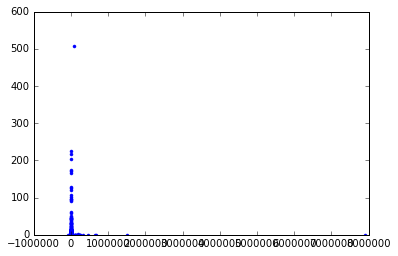

In [88]:
plt.plot(info['tE_ml_bell'], info['chisqr_bell'],'b.')

In [89]:
(info[['name', 'rho']][(info.chisqr_bell==0) & (info.rho>1)])

,name,rho
3113,mag.dcnormffp_0_82_343.det.lc.W149,1.05995
3331,mag.dcnormffp_0_82_561.det.lc.W149,2.59313
3351,mag.dcnormffp_0_82_581.det.lc.W149,3.13442
3875,mag.dcnormffp_0_82_1105.det.lc.W149,4.18938
4371,mag.dcnormffp_0_82_1601.det.lc.W149,1.08776
4510,mag.dcnormffp_0_82_1740.det.lc.W149,1.55858
4691,mag.dcnormffp_0_82_1921.det.lc.W149,1.82299


/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/ticker.py:1593: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


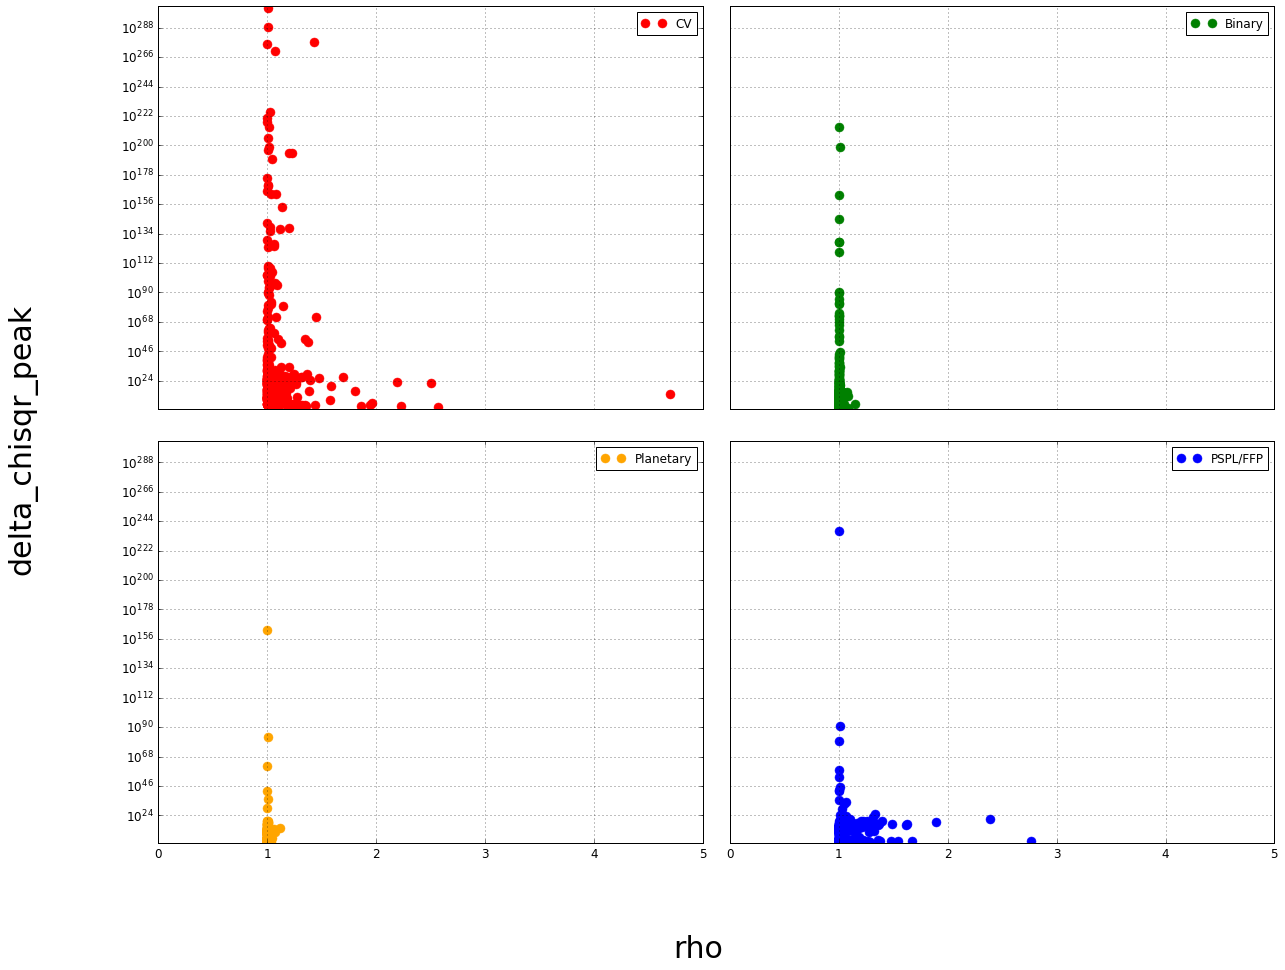

In [42]:
# General format for plotting different parameters versus each other 

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

x = 'rho'
y = 'delta_chisqr_peak'
c = 1
b = 1#2458234

axs[0,0].plot((info[x][info['type']==0]).astype(float).abs()+b,c*(info[y][info['type']==0]).astype(float).abs(), '.',markersize=18, label= 'CV',color='r')
axs[0,0].grid()
axs[0,0].legend()
axs[0,1].plot((info[x][info['type']==1]).astype(float).abs()+b,c*(info[y][info['type']==1]).astype(float).abs(), '.',markersize=18, label= 'Binary', color='g')
#axs[0,1].plot((info[x][info['type']==1]).astype(float).abs(),(info[x][info['type']==1]).astype(float).abs(), 'r-')
axs[0,1].grid()
axs[0,1].legend()
axs[1,0].plot((info[x][info['type']==2]).astype(float).abs()+b,c*(info[y][info['type']==2]).astype(float).abs(), '.',markersize=18, label= 'Planetary',  color = 'orange')
#axs[1,0].plot((info[x][info['type']==2]).astype(float).abs(),(info[x][info['type']==2]).astype(float).abs(), 'g-')
axs[1,0].grid()
axs[1,0].legend()
axs[1,1].plot((info[x][info['type']==3]).astype(float).abs()+b,c*(info[y][info['type']==3]).astype(float).abs(), '.',markersize=18, label= 'PSPL/FFP', color='blue')
#axs[1,1].plot((info[x][info['type']==3]).astype(float).abs(),(info[x][info['type']==3]).astype(float).abs(), 'r-')
axs[1,1].grid()
axs[1,1].legend()


axs[0, 1].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[0, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off',length=0)

axs[0, 0].tick_params(axis='y',which='both', labelsize=12)
axs[1, 0].tick_params(axis='both',which='both', labelsize=12)
axs[1, 1].tick_params(axis='x',which='both', labelsize=12)


plt.yscale('log')
#plt.xscale('log')



axs[0, 0].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[1, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off', length=0)

plt.xlim(0,5)
#plt.ylim(1e-10,1e-3)

# axs[0,0].set_ylim(ylim)
# axs[0,0].set_xlim(xlim)
# axs[0,1].set_ylim(ylim)
# axs[0,1].set_xlim(xlim)
# axs[1,0].set_ylim(ylim)
# axs[1,0].set_xlim(xlim)
# axs[1,1].set_ylim(ylim)
# axs[1,1].set_xlim(xlim)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.05, hspace=0.08) 

fig.text(0.5, 0.02, x, ha='center',size=30)
fig.text(0.02, 0.5, y, va='center', rotation='vertical',size=30)

fig = plt.gcf()
fig.set_size_inches(20.0,15.0)
#fig.savefig('a4-a2.png')

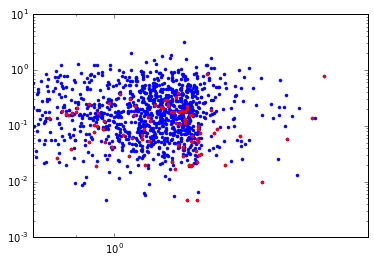

In [568]:
plt.plot(info['b_ml_bell'][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)& (info.tE_ml_bell != 0.0)],
         info['chisqr_PSPL'][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)& (info.tE_ml_bell != 0.0) ],'b.')
plt.plot(info['b_ml_bell'][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)& (info.rho>0.1)& (info.tE_ml_bell != 0.0)],
         info['chisqr_PSPL'][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)& (info.rho>0.1) & (info.tE_ml_bell != 0.0)],'r.')
plt.xlim(0.8,2)
plt.xscale('log')
plt.yscale('log')

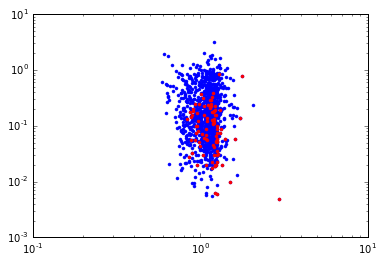

In [567]:
plt.plot(info['b_ml_bell'][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)& (info.tE_ml_bell != 0.0)],
         info['chisqr_bell'][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)& (info.tE_ml_bell != 0.0) ],'b.')
plt.plot(info['b_ml_bell'][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)& (info.rho>0.1)& (info.tE_ml_bell != 0.0)],
         info['chisqr_bell'][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)& (info.rho>0.1) & (info.tE_ml_bell != 0.0)],'r.')
# plt.ylim(-2,0)
plt.xscale('log')
plt.yscale('log')

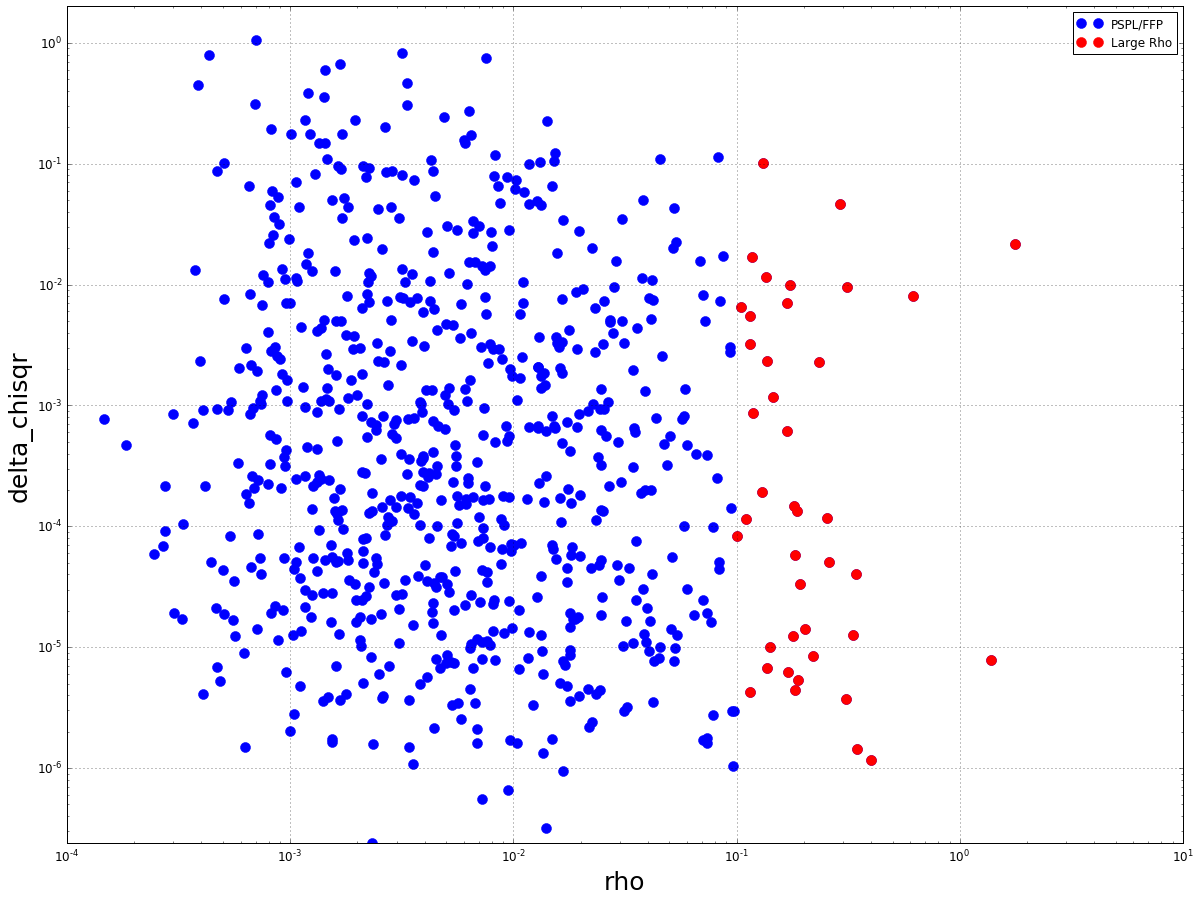

In [496]:
# General format for plotting different parameters versus each other 

plt.figure()

x = 'rho'
y = 'delta_chisqr'
c = 1


plt.plot((info[x][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)]).astype(float).abs(),
         c*(info[y][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10)]).astype(float), 'b.',markersize=20, label= 'PSPL/FFP')
#plt.plot((info['tE'][info['type']==3]).astype(float).abs(),c*(info['tE'][info['type']==3]).astype(float).abs(), 'k-')


plt.plot((info[x][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10) &(info.rho>0.1)]).astype(float).abs(),
         c*(info[y][(info['type']==3) & (np.abs(info.t0-info.t0_ml_bell)<10) &(info.rho>0.1)]).astype(float), 'r.',markersize=20, label= 'Large Rho')
#plt.plot(info['tE_ml_bell'][(info['type']==3)], info['rho'][(info['type']==3) ], 'r.')

#plt.plot((info[x][info['type']==0]).astype(float).abs(),c*(info[y][info['type']==0]).astype(float).abs(), '.',markersize=18, label= 'CV')
#plt.plot((info[x][info['type']==1]).astype(float).abs(),c*(info[y][info['type']==1]).astype(float).abs(), '.',markersize=18, label= 'Binary')
#plt.plot((info[x][info['type']==2]).astype(float).abs(),c*(info[y][info['type']==2]).astype(float).abs(), '.',markersize=18, label= 'Planetary')





plt.grid()
plt.legend()


plt.tick_params(axis='both',which='both', labelsize=12)

plt.yscale('log')
plt.xscale('log')

#plt.xlim(2458346.505461,2460059.241444)
plt.ylim(-2,2)


plt.xlabel(x, size=25)
plt.ylabel(y, size=25)


fig = plt.gcf()
fig.set_size_inches(20.0,15.0)
#fig.savefig('a4-a2.png')

In [188]:
info[['name', 't0', 'tE','rho', 't0_ml_bell', 'tE_ml_bell', 'b_ml_bell', 'delta_chisqr']][(info.delta_chisqr>0.1) & (info.type==3)]

,name,t0,tE,rho,t0_ml_bell,tE_ml_bell,b_ml_bell,delta_chisqr
2944,mag.dcnormffp_0_82_175.det.lc.W149,150.514244,4.301280,0.078295,150.514573,1.747110,0.976756,0.135932
3007,mag.dcnormffp_0_82_238.det.lc.W149,509.904209,11.487400,0.003643,509.904203,3.102328,0.824947,0.476257
3359,mag.dcnormffp_0_82_590.det.lc.W149,1642.449689,0.881454,0.011361,1642.449570,0.092457,0.628926,0.144085
3707,mag.dcnormffp_0_82_938.det.lc.W149,331.967557,49.071000,0.004609,331.775539,24.420661,1.062053,0.123794
3824,mag.dcnormffp_0_82_1055.det.lc.W149,134.873882,13.120000,0.015865,134.873360,3.069809,0.767903,0.723770
3825,mag.dcnormffp_0_82_1056.det.lc.W149,534.515760,13.270500,0.004075,534.516875,2.102749,0.681045,0.725699
4225,mag.dcnormffp_0_82_1456.det.lc.W149,1777.917057,5.605120,0.005793,1777.915914,0.532724,0.610538,1.647917
4264,mag.dcnormffp_0_82_1495.det.lc.W149,1429.887947,9.696540,0.021757,1429.889793,2.429377,0.808293,0.551269
4287,mag.dcnormffp_0_82_1518.det.lc.W149,492.415925,6.317530,0.009750,492.415099,1.130486,0.716161,0.847246
4364,mag.dcnormffp_0_82_1595.det.lc.W149,1605.926433,10.036300,0.003316,1605.924214,1.087416,0.639721,0.300512


In [176]:
info_FFP = (info[(info.tE<2) &(info.type==3)])


In [177]:
info_FFP = info_FFP.reset_index()

In [179]:
#Fitting Cauchy to Data Challenge light curves


direc.sort()
result = {'name':[], 't0_ml_bell':[], 'tE_ml_bell':[], 'b_ml_bell':[],'am_ml_bell':[],'guess_bell':[],
          'solution_bell':[], 'chisqr_bell':[], 't0_ml_PSPL':[], 'tE_ml_PSPL':[], 'u0_ml_PSPL':[],'guess_PSPL':[],
          'solution_PSPL':[], 'chisqr_PSPL':[], 'xdata': [], 'ydata': [], 'yerr': [], 'event': []}
c = 0 

for f in tqdm(info_FFP.name):
    #print f
    
    if  f.endswith('.W149') and f.startswith('mag.'):#f.endswith('.txt') and f.split('_')[2].startswith('W'):
        
        
        print c
        c = c +1

        try:
            t,m,e = np.loadtxt(temp+str(f),unpack=True, usecols=(0,1, 2))

            lightcurve = np.zeros((len(t),4))
            lightcurve[:,0] = t
            lightcurve[:,1] = m
            lightcurve[:,2] = e
            peak = t[np.argmin(m)]

            (baseline, event, it0) = localize_event(lightcurve, peak,50)
            base = np.round(np.median(lightcurve[baseline,1]),4)
            mag_peak = min(lightcurve[:,1][event])
            A = 10 ** (0.4*(base - lightcurve[:,1]))
            lightcurve[:,3] = A




            PSPL_init_par_test = estimate_init_param(lightcurve, peak, 'PSPL',
                                                baseline, event, it0)

            tE_range = [0.01, 0.1, 1.0, 10.0]
            trials = [[],[],[]]

            for tE in tE_range:

                PSPL_init_par_test[2] = tE

                try:
                    (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peak, lightcurve[:,3], p0=PSPL_init_par_test)


                except RuntimeError:

                    traceback.print_exc()

                    (baseline, event, it0) = localize_event(lightcurve, peak,10)
                    PSPL_init_par_test = estimate_init_param(lightcurve, peak, 'PSPL',
                                                        baseline, event, it0)
                    (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peak, lightcurve[:3], p0=PSPL_init_par_test)

                PSPLfx_test = PSPL(lightcurve[:,0]-peak,PSPLfit_test[0],PSPLfit_test[1],PSPLfit_test[2])
                PSPLfx2_test = base*np.ones(len(PSPLfx_test)) + (-2.5 * np.log10(PSPLfx_test))
                PSPL_chisq_test = calc_chisq(lightcurve,PSPLfx2_test)

                trials[0].append(PSPL_init_par_test)
                trials[1].append(PSPLfit_test)
                trials[2].append(PSPL_chisq_test)

            PSPL_chisq = np.min(trials[2])
            PSPLfit = trials[1][np.argmin(PSPL_chisq_test)]
            PSPL_init_par = trials[0][np.argmin(PSPL_chisq_test)]
            #print PSPL_init_par


            guess_PSPL = PSPL(lightcurve[:,0]-peak, PSPL_init_par[0], PSPL_init_par[1],PSPL_init_par[2])

            PSPLfx = PSPL(lightcurve[:,0]-peak,PSPLfit[0],PSPLfit[1],PSPLfit[2])
            PSPLfx = base*np.ones(len(PSPLfx)) + (-2.5 * np.log10(PSPLfx))




            # Fitting Bell vurve

            b_init_par = estimate_init_param(lightcurve, peak, 'bellcurve',
                                         baseline, event, it0)
            b_init_par[1] = 1

            try: 
                (bfit,bcov) = optimize.curve_fit(bell_curve,lightcurve[:,0]-peak,
                                                            -lightcurve[:,1]+np.median(lightcurve[baseline,1]),
                                                             p0=b_init_par)
            except RuntimeError:

                traceback.print_exc()
                (baseline, event, it0) = localize_event(lightcurve, peak,10)
                b_init_par = estimate_init_param(lightcurve, peak, 'bellcurve', baseline, event, it0)
                (bfit,bcov) = optimize.curve_fit(bell_curve,lightcurve[:,0]-peak,
                                                        -lightcurve[:,1]+np.median(lightcurve[baseline,1]),
                                                         p0=b_init_par)

            guess_Bell = np.median(lightcurve[baseline,1]) -bell_curve(lightcurve[:,0]-peaks[0]
                                                , b_init_par[0], b_init_par[1],
                                                 b_init_par[2], b_init_par[3])

            bfx = bell_curve(lightcurve[:,0]-peak,bfit[0],bfit[1],bfit[2],bfit[3])
            bfx = np.median(lightcurve[baseline,1]) - bfx

            bell_chisq = calc_chisq(lightcurve,bfx)
            
            result['name'].append(f)
            result['t0_ml_bell'].append(bfit[2]+peak)
            result['tE_ml_bell'].append(bfit[0])
            result['b_ml_bell'].append(bfit[1])
            result['am_ml_bell'].append(bfit[3])
            result['guess_bell'].append(guess_Bell)
            result['solution_bell'].append(bfx)
            result['chisqr_bell'].append(bell_chisq)
            result['t0_ml_PSPL'].append(PSPLfit[0]+peak)
            result['tE_ml_PSPL'].append(PSPLfit[2])
            result['u0_ml_PSPL'].append(PSPLfit[1])
    #            result['guess_PSPL'].append(guess_PSPL)
            result['solution_PSPL'].append(PSPLfx)
            result['chisqr_PSPL'].append(PSPL_chisq)
            result['event'].append(event)
            result['xdata'].append(t)
            result['ydata'].append(m)
            result['yerr'].append(e)
            
            
    except (RuntimeError, TypeError, NameError, ValueError, IOError):
        traceback.print_exc()
        pass
#     if c == 4:
#         break

print 'done'










  0%|          | 0/1266 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<ipython-input-179-96d31a3cd316>", line 48, in <module>
    (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peak, lightcurve[:,3], p0=PSPL_init_par_test)
  File "/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/optimize/minpack.py", line 748, in curve_fit
    raise RuntimeError("Optimal parameters not found: " + errmsg)
RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Traceback (most recent call last):
  File "<ipython-input-179-96d31a3cd316>", line 58, in <module>
    (PSPLfit_test,PSPLcov) = optimize.curve_fit(PSPL,lightcurve[:,0]-peak, lightcurve[:3], p0=PSPL_init_par_test)
  File "/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/optimize/minpack.py", line 744, in curve_fit
    res = leastsq(func, p0, Dfun=jac, full_output=1, **kwargs)
  File "/Users/Research/Libr

done


In [222]:
info_FFP['t0_ml'] = np.zeros(len(info_FFP))
info_FFP['tE_ml'] = np.zeros(len(info_FFP))
info_FFP['b_ml'] = np.zeros(len(info_FFP))
info_FFP['am_ml'] = np.zeros(len(info_FFP))

In [223]:
for i in range(len(result_FFP['name'])):

    if result_FFP['name'][i].split('.lc')[0].endswith('all'): 
        result_FFP['name'][i] = result_FFP['name'][i].split('all')[0]+'det'+result_FFP['name'][i].split('all')[1]

In [224]:
info_FFP['name'][8]

'mag.dcnormffp_0_82_9.det.lc.W149'

In [225]:
for i in range (len(result_FFP['name'])):
    
    if result_FFP['name'][i] in info_FFP.name:
        print result_FFP['name'][i]

In [226]:

for i in tqdm(range(len(result_FFP['name']))):
     
    print result_FFP['name'][i]
    info_FFP.loc[info_FFP.name == result_FFP['name'][i], 't0_ml'] = result_FFP['t0_ml'][i]
    info_FFP.loc[info_FFP.name == result_FFP['name'][i], 'tE_ml'] = result_FFP['tE_ml'][i]
    info_FFP.loc[info_FFP.name == result_FFP['name'][i], 'b_ml'] = result_FFP['b_ml'][i]
    info_FFP.loc[info_FFP.name == result_FFP['name'][i], 'am_ml'] = result_FFP['am_ml'][i]
    
    if not result_FFP['name'][i] in info.name.values:
        print result_FFP['name'][i]

  1%|          | 8/1007 [00:00<00:13, 71.45it/s]

mag.dcnormffp_0_82_1.det.lc.W149
mag.dcnormffp_0_82_2.det.lc.W149
mag.dcnormffp_0_82_3.det.lc.W149
mag.dcnormffp_0_82_4.det.lc.W149
mag.dcnormffp_0_82_5.det.lc.W149
mag.dcnormffp_0_82_6.det.lc.W149
mag.dcnormffp_0_82_7.det.lc.W149
mag.dcnormffp_0_82_15.det.lc.W149
mag.dcnormffp_0_82_20.det.lc.W149
mag.dcnormffp_0_82_21.det.lc.W149
mag.dcnormffp_0_82_22.det.lc.W149
mag.dcnormffp_0_82_23.det.lc.W149
mag.dcnormffp_0_82_24.det.lc.W149
mag.dcnormffp_0_82_25.det.lc.W149
mag.dcnormffp_0_82_26.det.lc.W149


  2%|▏         | 23/1007 [00:00<00:13, 71.19it/s]

mag.dcnormffp_0_82_27.det.lc.W149
mag.dcnormffp_0_82_28.det.lc.W149
mag.dcnormffp_0_82_29.det.lc.W149
mag.dcnormffp_0_82_30.det.lc.W149
mag.dcnormffp_0_82_31.det.lc.W149
mag.dcnormffp_0_82_40.det.lc.W149
mag.dcnormffp_0_82_42.det.lc.W149
mag.dcnormffp_0_82_43.det.lc.W149
mag.dcnormffp_0_82_47.det.lc.W149
mag.dcnormffp_0_82_48.det.lc.W149
mag.dcnormffp_0_82_49.det.lc.W149
mag.dcnormffp_0_82_50.det.lc.W149
mag.dcnormffp_0_82_51.det.lc.W149
mag.dcnormffp_0_82_60.det.lc.W149
mag.dcnormffp_0_82_61.det.lc.W149


  4%|▎         | 37/1007 [00:00<00:13, 70.41it/s]

mag.dcnormffp_0_82_66.det.lc.W149
mag.dcnormffp_0_82_67.det.lc.W149
mag.dcnormffp_0_82_68.det.lc.W149
mag.dcnormffp_0_82_69.det.lc.W149
mag.dcnormffp_0_82_70.det.lc.W149
mag.dcnormffp_0_82_71.det.lc.W149
mag.dcnormffp_0_82_72.det.lc.W149
mag.dcnormffp_0_82_73.det.lc.W149
mag.dcnormffp_0_82_74.det.lc.W149
mag.dcnormffp_0_82_80.det.lc.W149
mag.dcnormffp_0_82_81.det.lc.W149
mag.dcnormffp_0_82_82.det.lc.W149
mag.dcnormffp_0_82_83.det.lc.W149
mag.dcnormffp_0_82_84.det.lc.W149


  5%|▍         | 50/1007 [00:00<00:14, 67.46it/s]

mag.dcnormffp_0_82_85.det.lc.W149
mag.dcnormffp_0_82_86.det.lc.W149
mag.dcnormffp_0_82_87.det.lc.W149
mag.dcnormffp_0_82_91.det.lc.W149
mag.dcnormffp_0_82_100.det.lc.W149
mag.dcnormffp_0_82_101.det.lc.W149
mag.dcnormffp_0_82_102.det.lc.W149
mag.dcnormffp_0_82_103.det.lc.W149
mag.dcnormffp_0_82_104.det.lc.W149
mag.dcnormffp_0_82_105.det.lc.W149
mag.dcnormffp_0_82_106.det.lc.W149
mag.dcnormffp_0_82_108.det.lc.W149


  6%|▋         | 63/1007 [00:00<00:14, 65.67it/s]

mag.dcnormffp_0_82_109.det.lc.W149
mag.dcnormffp_0_82_110.det.lc.W149
mag.dcnormffp_0_82_111.det.lc.W149
mag.dcnormffp_0_82_115.det.lc.W149
mag.dcnormffp_0_82_121.det.lc.W149
mag.dcnormffp_0_82_122.det.lc.W149
mag.dcnormffp_0_82_123.det.lc.W149
mag.dcnormffp_0_82_124.det.lc.W149
mag.dcnormffp_0_82_125.det.lc.W149
mag.dcnormffp_0_82_126.det.lc.W149
mag.dcnormffp_0_82_127.det.lc.W149
mag.dcnormffp_0_82_128.det.lc.W149
mag.dcnormffp_0_82_129.det.lc.W149
mag.dcnormffp_0_82_130.det.lc.W149
mag.dcnormffp_0_82_131.det.lc.W149


  8%|▊         | 78/1007 [00:01<00:13, 66.59it/s]

mag.dcnormffp_0_82_141.det.lc.W149
mag.dcnormffp_0_82_142.det.lc.W149
mag.dcnormffp_0_82_143.det.lc.W149
mag.dcnormffp_0_82_144.det.lc.W149
mag.dcnormffp_0_82_145.det.lc.W149
mag.dcnormffp_0_82_146.det.lc.W149
mag.dcnormffp_0_82_147.det.lc.W149
mag.dcnormffp_0_82_148.det.lc.W149
mag.dcnormffp_0_82_152.det.lc.W149
mag.dcnormffp_0_82_160.det.lc.W149
mag.dcnormffp_0_82_161.det.lc.W149
mag.dcnormffp_0_82_162.det.lc.W149
mag.dcnormffp_0_82_164.det.lc.W149
mag.dcnormffp_0_82_166.det.lc.W149
mag.dcnormffp_0_82_180.det.lc.W149


  9%|▉         | 93/1007 [00:01<00:13, 66.88it/s]

mag.dcnormffp_0_82_181.det.lc.W149
mag.dcnormffp_0_82_182.det.lc.W149
mag.dcnormffp_0_82_183.det.lc.W149
mag.dcnormffp_0_82_184.det.lc.W149
mag.dcnormffp_0_82_186.det.lc.W149
mag.dcnormffp_0_82_189.det.lc.W149
mag.dcnormffp_0_82_192.det.lc.W149
mag.dcnormffp_0_82_193.det.lc.W149
mag.dcnormffp_0_82_201.det.lc.W149
mag.dcnormffp_0_82_202.det.lc.W149
mag.dcnormffp_0_82_203.det.lc.W149
mag.dcnormffp_0_82_204.det.lc.W149
mag.dcnormffp_0_82_205.det.lc.W149


 11%|█         | 107/1007 [00:01<00:13, 65.00it/s]

mag.dcnormffp_0_82_209.det.lc.W149
mag.dcnormffp_0_82_210.det.lc.W149
mag.dcnormffp_0_82_211.det.lc.W149
mag.dcnormffp_0_82_220.det.lc.W149
mag.dcnormffp_0_82_223.det.lc.W149
mag.dcnormffp_0_82_225.det.lc.W149
mag.dcnormffp_0_82_226.det.lc.W149
mag.dcnormffp_0_82_227.det.lc.W149
mag.dcnormffp_0_82_228.det.lc.W149
mag.dcnormffp_0_82_229.det.lc.W149
mag.dcnormffp_0_82_231.det.lc.W149
mag.dcnormffp_0_82_232.det.lc.W149


 12%|█▏        | 122/1007 [00:01<00:13, 65.03it/s]

mag.dcnormffp_0_82_241.det.lc.W149
mag.dcnormffp_0_82_243.det.lc.W149
mag.dcnormffp_0_82_245.det.lc.W149
mag.dcnormffp_0_82_246.det.lc.W149
mag.dcnormffp_0_82_247.det.lc.W149
mag.dcnormffp_0_82_248.det.lc.W149
mag.dcnormffp_0_82_250.det.lc.W149
mag.dcnormffp_0_82_251.det.lc.W149
mag.dcnormffp_0_82_252.det.lc.W149
mag.dcnormffp_0_82_253.det.lc.W149
mag.dcnormffp_0_82_254.det.lc.W149
mag.dcnormffp_0_82_261.det.lc.W149
mag.dcnormffp_0_82_263.det.lc.W149
mag.dcnormffp_0_82_264.det.lc.W149
mag.dcnormffp_0_82_265.det.lc.W149


 14%|█▎        | 136/1007 [00:02<00:13, 65.37it/s]

mag.dcnormffp_0_82_266.det.lc.W149
mag.dcnormffp_0_82_267.det.lc.W149
mag.dcnormffp_0_82_269.det.lc.W149
mag.dcnormffp_0_82_270.det.lc.W149
mag.dcnormffp_0_82_280.det.lc.W149
mag.dcnormffp_0_82_281.det.lc.W149
mag.dcnormffp_0_82_282.det.lc.W149
mag.dcnormffp_0_82_283.det.lc.W149
mag.dcnormffp_0_82_284.det.lc.W149
mag.dcnormffp_0_82_285.det.lc.W149
mag.dcnormffp_0_82_286.det.lc.W149
mag.dcnormffp_0_82_288.det.lc.W149
mag.dcnormffp_0_82_289.det.lc.W149
mag.dcnormffp_0_82_290.det.lc.W149
mag.dcnormffp_0_82_295.det.lc.W149


 15%|█▍        | 151/1007 [00:02<00:13, 65.44it/s]

mag.dcnormffp_0_82_300.det.lc.W149
mag.dcnormffp_0_82_302.det.lc.W149
mag.dcnormffp_0_82_303.det.lc.W149
mag.dcnormffp_0_82_305.det.lc.W149
mag.dcnormffp_0_82_306.det.lc.W149
mag.dcnormffp_0_82_307.det.lc.W149
mag.dcnormffp_0_82_308.det.lc.W149
mag.dcnormffp_0_82_309.det.lc.W149
mag.dcnormffp_0_82_310.det.lc.W149
mag.dcnormffp_0_82_311.det.lc.W149
mag.dcnormffp_0_82_312.det.lc.W149
mag.dcnormffp_0_82_314.det.lc.W149
mag.dcnormffp_0_82_320.det.lc.W149


 16%|█▋        | 166/1007 [00:02<00:12, 65.36it/s]

mag.dcnormffp_0_82_321.det.lc.W149
mag.dcnormffp_0_82_322.det.lc.W149
mag.dcnormffp_0_82_323.det.lc.W149
mag.dcnormffp_0_82_325.det.lc.W149
mag.dcnormffp_0_82_326.det.lc.W149
mag.dcnormffp_0_82_327.det.lc.W149
mag.dcnormffp_0_82_328.det.lc.W149
mag.dcnormffp_0_82_329.det.lc.W149
mag.dcnormffp_0_82_330.det.lc.W149
mag.dcnormffp_0_82_331.det.lc.W149
mag.dcnormffp_0_82_332.det.lc.W149
mag.dcnormffp_0_82_335.det.lc.W149
mag.dcnormffp_0_82_340.det.lc.W149
mag.dcnormffp_0_82_341.det.lc.W149
mag.dcnormffp_0_82_343.det.lc.W149


 18%|█▊        | 181/1007 [00:02<00:12, 65.74it/s]

mag.dcnormffp_0_82_344.det.lc.W149
mag.dcnormffp_0_82_345.det.lc.W149
mag.dcnormffp_0_82_346.det.lc.W149
mag.dcnormffp_0_82_348.det.lc.W149
mag.dcnormffp_0_82_352.det.lc.W149
mag.dcnormffp_0_82_353.det.lc.W149
mag.dcnormffp_0_82_360.det.lc.W149
mag.dcnormffp_0_82_361.det.lc.W149
mag.dcnormffp_0_82_362.det.lc.W149
mag.dcnormffp_0_82_363.det.lc.W149
mag.dcnormffp_0_82_366.det.lc.W149
mag.dcnormffp_0_82_368.det.lc.W149
mag.dcnormffp_0_82_369.det.lc.W149
mag.dcnormffp_0_82_370.det.lc.W149
mag.dcnormffp_0_82_371.det.lc.W149


 19%|█▉        | 195/1007 [00:02<00:12, 65.32it/s]

mag.dcnormffp_0_82_372.det.lc.W149
mag.dcnormffp_0_82_373.det.lc.W149
mag.dcnormffp_0_82_380.det.lc.W149
mag.dcnormffp_0_82_381.det.lc.W149
mag.dcnormffp_0_82_383.det.lc.W149
mag.dcnormffp_0_82_384.det.lc.W149
mag.dcnormffp_0_82_386.det.lc.W149
mag.dcnormffp_0_82_388.det.lc.W149
mag.dcnormffp_0_82_390.det.lc.W149
mag.dcnormffp_0_82_393.det.lc.W149
mag.dcnormffp_0_82_400.det.lc.W149
mag.dcnormffp_0_82_401.det.lc.W149


 21%|██        | 210/1007 [00:03<00:12, 65.53it/s]

mag.dcnormffp_0_82_402.det.lc.W149
mag.dcnormffp_0_82_403.det.lc.W149
mag.dcnormffp_0_82_404.det.lc.W149
mag.dcnormffp_0_82_409.det.lc.W149
mag.dcnormffp_0_82_410.det.lc.W149
mag.dcnormffp_0_82_411.det.lc.W149
mag.dcnormffp_0_82_412.det.lc.W149
mag.dcnormffp_0_82_415.det.lc.W149
mag.dcnormffp_0_82_420.det.lc.W149
mag.dcnormffp_0_82_421.det.lc.W149
mag.dcnormffp_0_82_422.det.lc.W149
mag.dcnormffp_0_82_423.det.lc.W149
mag.dcnormffp_0_82_424.det.lc.W149
mag.dcnormffp_0_82_425.det.lc.W149
mag.dcnormffp_0_82_428.det.lc.W149


 22%|██▏       | 218/1007 [00:03<00:12, 65.72it/s]

mag.dcnormffp_0_82_429.det.lc.W149
mag.dcnormffp_0_82_430.det.lc.W149
mag.dcnormffp_0_82_433.det.lc.W149
mag.dcnormffp_0_82_441.det.lc.W149
mag.dcnormffp_0_82_443.det.lc.W149
mag.dcnormffp_0_82_444.det.lc.W149
mag.dcnormffp_0_82_446.det.lc.W149
mag.dcnormffp_0_82_450.det.lc.W149
mag.dcnormffp_0_82_453.det.lc.W149
mag.dcnormffp_0_82_461.det.lc.W149
mag.dcnormffp_0_82_462.det.lc.W149
mag.dcnormffp_0_82_464.det.lc.W149
mag.dcnormffp_0_82_465.det.lc.W149
mag.dcnormffp_0_82_466.det.lc.W149
mag.dcnormffp_0_82_467.det.lc.W149


 23%|██▎       | 233/1007 [00:03<00:11, 65.73it/s]

mag.dcnormffp_0_82_469.det.lc.W149
mag.dcnormffp_0_82_470.det.lc.W149
mag.dcnormffp_0_82_472.det.lc.W149
mag.dcnormffp_0_82_480.det.lc.W149
mag.dcnormffp_0_82_481.det.lc.W149
mag.dcnormffp_0_82_482.det.lc.W149
mag.dcnormffp_0_82_484.det.lc.W149
mag.dcnormffp_0_82_485.det.lc.W149
mag.dcnormffp_0_82_486.det.lc.W149
mag.dcnormffp_0_82_489.det.lc.W149
mag.dcnormffp_0_82_490.det.lc.W149
mag.dcnormffp_0_82_493.det.lc.W149
mag.dcnormffp_0_82_494.det.lc.W149


 25%|██▍       | 248/1007 [00:03<00:11, 65.68it/s]

mag.dcnormffp_0_82_500.det.lc.W149
mag.dcnormffp_0_82_501.det.lc.W149
mag.dcnormffp_0_82_502.det.lc.W149
mag.dcnormffp_0_82_503.det.lc.W149
mag.dcnormffp_0_82_504.det.lc.W149
mag.dcnormffp_0_82_505.det.lc.W149
mag.dcnormffp_0_82_506.det.lc.W149
mag.dcnormffp_0_82_508.det.lc.W149
mag.dcnormffp_0_82_509.det.lc.W149
mag.dcnormffp_0_82_510.det.lc.W149
mag.dcnormffp_0_82_511.det.lc.W149
mag.dcnormffp_0_82_512.det.lc.W149
mag.dcnormffp_0_82_513.det.lc.W149
mag.dcnormffp_0_82_515.det.lc.W149
mag.dcnormffp_0_82_520.det.lc.W149


 26%|██▌       | 264/1007 [00:04<00:11, 65.98it/s]

mag.dcnormffp_0_82_521.det.lc.W149
mag.dcnormffp_0_82_522.det.lc.W149
mag.dcnormffp_0_82_523.det.lc.W149
mag.dcnormffp_0_82_524.det.lc.W149
mag.dcnormffp_0_82_526.det.lc.W149
mag.dcnormffp_0_82_527.det.lc.W149
mag.dcnormffp_0_82_529.det.lc.W149
mag.dcnormffp_0_82_531.det.lc.W149
mag.dcnormffp_0_82_541.det.lc.W149
mag.dcnormffp_0_82_542.det.lc.W149
mag.dcnormffp_0_82_543.det.lc.W149
mag.dcnormffp_0_82_544.det.lc.W149
mag.dcnormffp_0_82_545.det.lc.W149
mag.dcnormffp_0_82_546.det.lc.W149
mag.dcnormffp_0_82_547.det.lc.W149


 28%|██▊       | 278/1007 [00:04<00:11, 65.82it/s]

mag.dcnormffp_0_82_549.det.lc.W149
mag.dcnormffp_0_82_551.det.lc.W149
mag.dcnormffp_0_82_555.det.lc.W149
mag.dcnormffp_0_82_560.det.lc.W149
mag.dcnormffp_0_82_563.det.lc.W149
mag.dcnormffp_0_82_564.det.lc.W149
mag.dcnormffp_0_82_565.det.lc.W149
mag.dcnormffp_0_82_566.det.lc.W149
mag.dcnormffp_0_82_567.det.lc.W149
mag.dcnormffp_0_82_568.det.lc.W149
mag.dcnormffp_0_82_570.det.lc.W149
mag.dcnormffp_0_82_571.det.lc.W149
mag.dcnormffp_0_82_572.det.lc.W149


 29%|██▉       | 292/1007 [00:04<00:10, 65.66it/s]

mag.dcnormffp_0_82_574.det.lc.W149
mag.dcnormffp_0_82_575.det.lc.W149
mag.dcnormffp_0_82_581.det.lc.W149
mag.dcnormffp_0_82_582.det.lc.W149
mag.dcnormffp_0_82_584.det.lc.W149
mag.dcnormffp_0_82_585.det.lc.W149
mag.dcnormffp_0_82_586.det.lc.W149
mag.dcnormffp_0_82_587.det.lc.W149
mag.dcnormffp_0_82_588.det.lc.W149
mag.dcnormffp_0_82_589.det.lc.W149
mag.dcnormffp_0_82_590.det.lc.W149
mag.dcnormffp_0_82_600.det.lc.W149
mag.dcnormffp_0_82_601.det.lc.W149
mag.dcnormffp_0_82_602.det.lc.W149


 31%|███       | 308/1007 [00:04<00:10, 65.95it/s]

mag.dcnormffp_0_82_603.det.lc.W149
mag.dcnormffp_0_82_604.det.lc.W149
mag.dcnormffp_0_82_605.det.lc.W149
mag.dcnormffp_0_82_606.det.lc.W149
mag.dcnormffp_0_82_607.det.lc.W149
mag.dcnormffp_0_82_609.det.lc.W149
mag.dcnormffp_0_82_610.det.lc.W149
mag.dcnormffp_0_82_612.det.lc.W149
mag.dcnormffp_0_82_621.det.lc.W149
mag.dcnormffp_0_82_623.det.lc.W149
mag.dcnormffp_0_82_624.det.lc.W149
mag.dcnormffp_0_82_625.det.lc.W149
mag.dcnormffp_0_82_627.det.lc.W149
mag.dcnormffp_0_82_628.det.lc.W149
mag.dcnormffp_0_82_630.det.lc.W149


 32%|███▏      | 324/1007 [00:04<00:10, 66.23it/s]

mag.dcnormffp_0_82_640.det.lc.W149
mag.dcnormffp_0_82_641.det.lc.W149
mag.dcnormffp_0_82_642.det.lc.W149
mag.dcnormffp_0_82_644.det.lc.W149
mag.dcnormffp_0_82_645.det.lc.W149
mag.dcnormffp_0_82_649.det.lc.W149
mag.dcnormffp_0_82_650.det.lc.W149
mag.dcnormffp_0_82_651.det.lc.W149
mag.dcnormffp_0_82_652.det.lc.W149
mag.dcnormffp_0_82_661.det.lc.W149
mag.dcnormffp_0_82_662.det.lc.W149
mag.dcnormffp_0_82_663.det.lc.W149
mag.dcnormffp_0_82_664.det.lc.W149
mag.dcnormffp_0_82_665.det.lc.W149
mag.dcnormffp_0_82_666.det.lc.W149


 34%|███▎      | 339/1007 [00:05<00:10, 66.21it/s]

mag.dcnormffp_0_82_667.det.lc.W149
mag.dcnormffp_0_82_669.det.lc.W149
mag.dcnormffp_0_82_681.det.lc.W149
mag.dcnormffp_0_82_683.det.lc.W149
mag.dcnormffp_0_82_684.det.lc.W149
mag.dcnormffp_0_82_687.det.lc.W149
mag.dcnormffp_0_82_689.det.lc.W149
mag.dcnormffp_0_82_690.det.lc.W149
mag.dcnormffp_0_82_691.det.lc.W149
mag.dcnormffp_0_82_692.det.lc.W149
mag.dcnormffp_0_82_693.det.lc.W149
mag.dcnormffp_0_82_700.det.lc.W149
mag.dcnormffp_0_82_701.det.lc.W149


 34%|███▍      | 346/1007 [00:05<00:09, 66.24it/s]

mag.dcnormffp_0_82_703.det.lc.W149
mag.dcnormffp_0_82_704.det.lc.W149
mag.dcnormffp_0_82_707.det.lc.W149
mag.dcnormffp_0_82_709.det.lc.W149
mag.dcnormffp_0_82_710.det.lc.W149
mag.dcnormffp_0_82_711.det.lc.W149
mag.dcnormffp_0_82_712.det.lc.W149
mag.dcnormffp_0_82_722.det.lc.W149
mag.dcnormffp_0_82_725.det.lc.W149
mag.dcnormffp_0_82_726.det.lc.W149
mag.dcnormffp_0_82_727.det.lc.W149
mag.dcnormffp_0_82_728.det.lc.W149
mag.dcnormffp_0_82_740.det.lc.W149


 36%|███▌      | 360/1007 [00:05<00:09, 66.12it/s]

mag.dcnormffp_0_82_741.det.lc.W149
mag.dcnormffp_0_82_742.det.lc.W149
mag.dcnormffp_0_82_744.det.lc.W149
mag.dcnormffp_0_82_745.det.lc.W149
mag.dcnormffp_0_82_746.det.lc.W149
mag.dcnormffp_0_82_748.det.lc.W149
mag.dcnormffp_0_82_749.det.lc.W149
mag.dcnormffp_0_82_751.det.lc.W149
mag.dcnormffp_0_82_752.det.lc.W149
mag.dcnormffp_0_82_753.det.lc.W149
mag.dcnormffp_0_82_761.det.lc.W149
mag.dcnormffp_0_82_762.det.lc.W149
mag.dcnormffp_0_82_765.det.lc.W149
mag.dcnormffp_0_82_766.det.lc.W149


 37%|███▋      | 376/1007 [00:05<00:09, 66.32it/s]

mag.dcnormffp_0_82_768.det.lc.W149
mag.dcnormffp_0_82_769.det.lc.W149
mag.dcnormffp_0_82_770.det.lc.W149
mag.dcnormffp_0_82_771.det.lc.W149
mag.dcnormffp_0_82_780.det.lc.W149
mag.dcnormffp_0_82_781.det.lc.W149
mag.dcnormffp_0_82_782.det.lc.W149
mag.dcnormffp_0_82_783.det.lc.W149
mag.dcnormffp_0_82_784.det.lc.W149
mag.dcnormffp_0_82_785.det.lc.W149
mag.dcnormffp_0_82_786.det.lc.W149
mag.dcnormffp_0_82_787.det.lc.W149
mag.dcnormffp_0_82_789.det.lc.W149
mag.dcnormffp_0_82_791.det.lc.W149


 39%|███▊      | 390/1007 [00:05<00:09, 65.79it/s]

mag.dcnormffp_0_82_792.det.lc.W149
mag.dcnormffp_0_82_793.det.lc.W149
mag.dcnormffp_0_82_801.det.lc.W149
mag.dcnormffp_0_82_804.det.lc.W149
mag.dcnormffp_0_82_805.det.lc.W149
mag.dcnormffp_0_82_807.det.lc.W149
mag.dcnormffp_0_82_808.det.lc.W149
mag.dcnormffp_0_82_809.det.lc.W149
mag.dcnormffp_0_82_810.det.lc.W149
mag.dcnormffp_0_82_811.det.lc.W149
mag.dcnormffp_0_82_820.det.lc.W149


 39%|███▉      | 397/1007 [00:06<00:09, 65.64it/s]

mag.dcnormffp_0_82_821.det.lc.W149
mag.dcnormffp_0_82_823.det.lc.W149
mag.dcnormffp_0_82_826.det.lc.W149
mag.dcnormffp_0_82_827.det.lc.W149
mag.dcnormffp_0_82_828.det.lc.W149
mag.dcnormffp_0_82_829.det.lc.W149
mag.dcnormffp_0_82_830.det.lc.W149
mag.dcnormffp_0_82_831.det.lc.W149
mag.dcnormffp_0_82_834.det.lc.W149
mag.dcnormffp_0_82_838.det.lc.W149
mag.dcnormffp_0_82_842.det.lc.W149
mag.dcnormffp_0_82_846.det.lc.W149
mag.dcnormffp_0_82_847.det.lc.W149
mag.dcnormffp_0_82_848.det.lc.W149


 41%|████      | 412/1007 [00:06<00:09, 65.79it/s]

mag.dcnormffp_0_82_849.det.lc.W149
mag.dcnormffp_0_82_850.det.lc.W149
mag.dcnormffp_0_82_861.det.lc.W149
mag.dcnormffp_0_82_862.det.lc.W149
mag.dcnormffp_0_82_863.det.lc.W149
mag.dcnormffp_0_82_864.det.lc.W149
mag.dcnormffp_0_82_865.det.lc.W149
mag.dcnormffp_0_82_867.det.lc.W149
mag.dcnormffp_0_82_868.det.lc.W149
mag.dcnormffp_0_82_870.det.lc.W149
mag.dcnormffp_0_82_871.det.lc.W149
mag.dcnormffp_0_82_872.det.lc.W149
mag.dcnormffp_0_82_880.det.lc.W149


 42%|████▏     | 426/1007 [00:06<00:08, 65.65it/s]

mag.dcnormffp_0_82_881.det.lc.W149
mag.dcnormffp_0_82_882.det.lc.W149
mag.dcnormffp_0_82_883.det.lc.W149
mag.dcnormffp_0_82_884.det.lc.W149
mag.dcnormffp_0_82_886.det.lc.W149
mag.dcnormffp_0_82_887.det.lc.W149
mag.dcnormffp_0_82_888.det.lc.W149
mag.dcnormffp_0_82_889.det.lc.W149
mag.dcnormffp_0_82_890.det.lc.W149
mag.dcnormffp_0_82_891.det.lc.W149
mag.dcnormffp_0_82_892.det.lc.W149
mag.dcnormffp_0_82_900.det.lc.W149
mag.dcnormffp_0_82_901.det.lc.W149
mag.dcnormffp_0_82_902.det.lc.W149


 44%|████▎     | 440/1007 [00:06<00:08, 65.63it/s]

mag.dcnormffp_0_82_903.det.lc.W149
mag.dcnormffp_0_82_904.det.lc.W149
mag.dcnormffp_0_82_905.det.lc.W149
mag.dcnormffp_0_82_906.det.lc.W149
mag.dcnormffp_0_82_907.det.lc.W149
mag.dcnormffp_0_82_908.det.lc.W149
mag.dcnormffp_0_82_909.det.lc.W149
mag.dcnormffp_0_82_910.det.lc.W149
mag.dcnormffp_0_82_911.det.lc.W149
mag.dcnormffp_0_82_913.det.lc.W149
mag.dcnormffp_0_82_914.det.lc.W149
mag.dcnormffp_0_82_915.det.lc.W149
mag.dcnormffp_0_82_920.det.lc.W149


 45%|████▌     | 454/1007 [00:06<00:08, 65.39it/s]

mag.dcnormffp_0_82_921.det.lc.W149
mag.dcnormffp_0_82_922.det.lc.W149
mag.dcnormffp_0_82_923.det.lc.W149
mag.dcnormffp_0_82_924.det.lc.W149
mag.dcnormffp_0_82_926.det.lc.W149
mag.dcnormffp_0_82_927.det.lc.W149
mag.dcnormffp_0_82_930.det.lc.W149
mag.dcnormffp_0_82_932.det.lc.W149
mag.dcnormffp_0_82_933.det.lc.W149
mag.dcnormffp_0_82_940.det.lc.W149
mag.dcnormffp_0_82_941.det.lc.W149
mag.dcnormffp_0_82_942.det.lc.W149
mag.dcnormffp_0_82_943.det.lc.W149


 46%|████▋     | 468/1007 [00:07<00:08, 65.17it/s]

mag.dcnormffp_0_82_944.det.lc.W149
mag.dcnormffp_0_82_945.det.lc.W149
mag.dcnormffp_0_82_946.det.lc.W149
mag.dcnormffp_0_82_947.det.lc.W149
mag.dcnormffp_0_82_948.det.lc.W149
mag.dcnormffp_0_82_949.det.lc.W149
mag.dcnormffp_0_82_950.det.lc.W149
mag.dcnormffp_0_82_951.det.lc.W149
mag.dcnormffp_0_82_960.det.lc.W149
mag.dcnormffp_0_82_961.det.lc.W149
mag.dcnormffp_0_82_962.det.lc.W149
mag.dcnormffp_0_82_963.det.lc.W149
mag.dcnormffp_0_82_964.det.lc.W149


 48%|████▊     | 483/1007 [00:07<00:08, 65.30it/s]

mag.dcnormffp_0_82_965.det.lc.W149
mag.dcnormffp_0_82_967.det.lc.W149
mag.dcnormffp_0_82_968.det.lc.W149
mag.dcnormffp_0_82_969.det.lc.W149
mag.dcnormffp_0_82_970.det.lc.W149
mag.dcnormffp_0_82_971.det.lc.W149
mag.dcnormffp_0_82_980.det.lc.W149
mag.dcnormffp_0_82_981.det.lc.W149
mag.dcnormffp_0_82_982.det.lc.W149
mag.dcnormffp_0_82_983.det.lc.W149
mag.dcnormffp_0_82_984.det.lc.W149
mag.dcnormffp_0_82_985.det.lc.W149
mag.dcnormffp_0_82_986.det.lc.W149
mag.dcnormffp_0_82_987.det.lc.W149


 49%|████▉     | 497/1007 [00:07<00:07, 65.10it/s]

mag.dcnormffp_0_82_988.det.lc.W149
mag.dcnormffp_0_82_989.det.lc.W149
mag.dcnormffp_0_82_991.det.lc.W149
mag.dcnormffp_0_82_992.det.lc.W149
mag.dcnormffp_0_82_1000.det.lc.W149
mag.dcnormffp_0_82_1001.det.lc.W149
mag.dcnormffp_0_82_1002.det.lc.W149
mag.dcnormffp_0_82_1004.det.lc.W149
mag.dcnormffp_0_82_1005.det.lc.W149
mag.dcnormffp_0_82_1007.det.lc.W149
mag.dcnormffp_0_82_1008.det.lc.W149
mag.dcnormffp_0_82_1009.det.lc.W149
mag.dcnormffp_0_82_1010.det.lc.W149


 51%|█████     | 511/1007 [00:07<00:07, 65.05it/s]

mag.dcnormffp_0_82_1013.det.lc.W149
mag.dcnormffp_0_82_1020.det.lc.W149
mag.dcnormffp_0_82_1021.det.lc.W149
mag.dcnormffp_0_82_1022.det.lc.W149
mag.dcnormffp_0_82_1023.det.lc.W149
mag.dcnormffp_0_82_1024.det.lc.W149
mag.dcnormffp_0_82_1025.det.lc.W149
mag.dcnormffp_0_82_1026.det.lc.W149
mag.dcnormffp_0_82_1028.det.lc.W149
mag.dcnormffp_0_82_1029.det.lc.W149
mag.dcnormffp_0_82_1030.det.lc.W149
mag.dcnormffp_0_82_1031.det.lc.W149
mag.dcnormffp_0_82_1040.det.lc.W149


 51%|█████▏    | 518/1007 [00:07<00:07, 64.97it/s]

mag.dcnormffp_0_82_1041.det.lc.W149
mag.dcnormffp_0_82_1042.det.lc.W149
mag.dcnormffp_0_82_1043.det.lc.W149
mag.dcnormffp_0_82_1044.det.lc.W149
mag.dcnormffp_0_82_1045.det.lc.W149
mag.dcnormffp_0_82_1047.det.lc.W149
mag.dcnormffp_0_82_1048.det.lc.W149
mag.dcnormffp_0_82_1049.det.lc.W149
mag.dcnormffp_0_82_1051.det.lc.W149
mag.dcnormffp_0_82_1052.det.lc.W149
mag.dcnormffp_0_82_1060.det.lc.W149
mag.dcnormffp_0_82_1061.det.lc.W149
mag.dcnormffp_0_82_1062.det.lc.W149
mag.dcnormffp_0_82_1063.det.lc.W149


 53%|█████▎    | 533/1007 [00:08<00:07, 64.84it/s]

mag.dcnormffp_0_82_1064.det.lc.W149
mag.dcnormffp_0_82_1066.det.lc.W149
mag.dcnormffp_0_82_1067.det.lc.W149
mag.dcnormffp_0_82_1068.det.lc.W149
mag.dcnormffp_0_82_1069.det.lc.W149
mag.dcnormffp_0_82_1070.det.lc.W149
mag.dcnormffp_0_82_1080.det.lc.W149
mag.dcnormffp_0_82_1081.det.lc.W149
mag.dcnormffp_0_82_1082.det.lc.W149
mag.dcnormffp_0_82_1084.det.lc.W149
mag.dcnormffp_0_82_1085.det.lc.W149
mag.dcnormffp_0_82_1086.det.lc.W149


 54%|█████▍    | 547/1007 [00:08<00:07, 64.72it/s]

mag.dcnormffp_0_82_1087.det.lc.W149
mag.dcnormffp_0_82_1088.det.lc.W149
mag.dcnormffp_0_82_1089.det.lc.W149
mag.dcnormffp_0_82_1090.det.lc.W149
mag.dcnormffp_0_82_1092.det.lc.W149
mag.dcnormffp_0_82_1094.det.lc.W149
mag.dcnormffp_0_82_1100.det.lc.W149
mag.dcnormffp_0_82_1102.det.lc.W149
mag.dcnormffp_0_82_1103.det.lc.W149
mag.dcnormffp_0_82_1104.det.lc.W149
mag.dcnormffp_0_82_1106.det.lc.W149
mag.dcnormffp_0_82_1107.det.lc.W149
mag.dcnormffp_0_82_1108.det.lc.W149


 56%|█████▌    | 561/1007 [00:08<00:06, 64.68it/s]

mag.dcnormffp_0_82_1109.det.lc.W149
mag.dcnormffp_0_82_1110.det.lc.W149
mag.dcnormffp_0_82_1111.det.lc.W149
mag.dcnormffp_0_82_1112.det.lc.W149
mag.dcnormffp_0_82_1113.det.lc.W149
mag.dcnormffp_0_82_1120.det.lc.W149
mag.dcnormffp_0_82_1121.det.lc.W149
mag.dcnormffp_0_82_1122.det.lc.W149
mag.dcnormffp_0_82_1123.det.lc.W149
mag.dcnormffp_0_82_1125.det.lc.W149
mag.dcnormffp_0_82_1126.det.lc.W149
mag.dcnormffp_0_82_1127.det.lc.W149
mag.dcnormffp_0_82_1128.det.lc.W149


 57%|█████▋    | 575/1007 [00:08<00:06, 64.65it/s]

mag.dcnormffp_0_82_1129.det.lc.W149
mag.dcnormffp_0_82_1130.det.lc.W149
mag.dcnormffp_0_82_1132.det.lc.W149
mag.dcnormffp_0_82_1140.det.lc.W149
mag.dcnormffp_0_82_1141.det.lc.W149
mag.dcnormffp_0_82_1142.det.lc.W149
mag.dcnormffp_0_82_1143.det.lc.W149
mag.dcnormffp_0_82_1144.det.lc.W149
mag.dcnormffp_0_82_1145.det.lc.W149
mag.dcnormffp_0_82_1146.det.lc.W149
mag.dcnormffp_0_82_1147.det.lc.W149
mag.dcnormffp_0_82_1149.det.lc.W149
mag.dcnormffp_0_82_1150.det.lc.W149


 58%|█████▊    | 589/1007 [00:09<00:06, 64.60it/s]

mag.dcnormffp_0_82_1153.det.lc.W149
mag.dcnormffp_0_82_1160.det.lc.W149
mag.dcnormffp_0_82_1161.det.lc.W149
mag.dcnormffp_0_82_1162.det.lc.W149
mag.dcnormffp_0_82_1163.det.lc.W149
mag.dcnormffp_0_82_1164.det.lc.W149
mag.dcnormffp_0_82_1165.det.lc.W149
mag.dcnormffp_0_82_1166.det.lc.W149
mag.dcnormffp_0_82_1167.det.lc.W149
mag.dcnormffp_0_82_1168.det.lc.W149
mag.dcnormffp_0_82_1169.det.lc.W149
mag.dcnormffp_0_82_1170.det.lc.W149
mag.dcnormffp_0_82_1171.det.lc.W149


 59%|█████▉    | 596/1007 [00:09<00:06, 64.55it/s]

mag.dcnormffp_0_82_1172.det.lc.W149
mag.dcnormffp_0_82_1182.det.lc.W149
mag.dcnormffp_0_82_1183.det.lc.W149
mag.dcnormffp_0_82_1184.det.lc.W149
mag.dcnormffp_0_82_1186.det.lc.W149
mag.dcnormffp_0_82_1188.det.lc.W149
mag.dcnormffp_0_82_1189.det.lc.W149
mag.dcnormffp_0_82_1190.det.lc.W149
mag.dcnormffp_0_82_1194.det.lc.W149
mag.dcnormffp_0_82_1200.det.lc.W149
mag.dcnormffp_0_82_1202.det.lc.W149
mag.dcnormffp_0_82_1204.det.lc.W149
mag.dcnormffp_0_82_1205.det.lc.W149


 61%|██████    | 610/1007 [00:09<00:06, 64.50it/s]

mag.dcnormffp_0_82_1206.det.lc.W149
mag.dcnormffp_0_82_1208.det.lc.W149
mag.dcnormffp_0_82_1209.det.lc.W149
mag.dcnormffp_0_82_1210.det.lc.W149
mag.dcnormffp_0_82_1220.det.lc.W149
mag.dcnormffp_0_82_1222.det.lc.W149
mag.dcnormffp_0_82_1223.det.lc.W149
mag.dcnormffp_0_82_1225.det.lc.W149
mag.dcnormffp_0_82_1226.det.lc.W149
mag.dcnormffp_0_82_1228.det.lc.W149
mag.dcnormffp_0_82_1229.det.lc.W149
mag.dcnormffp_0_82_1230.det.lc.W149
mag.dcnormffp_0_82_1231.det.lc.W149


 62%|██████▏   | 624/1007 [00:09<00:05, 64.45it/s]

mag.dcnormffp_0_82_1233.det.lc.W149
mag.dcnormffp_0_82_1240.det.lc.W149
mag.dcnormffp_0_82_1241.det.lc.W149
mag.dcnormffp_0_82_1242.det.lc.W149
mag.dcnormffp_0_82_1243.det.lc.W149
mag.dcnormffp_0_82_1244.det.lc.W149
mag.dcnormffp_0_82_1245.det.lc.W149
mag.dcnormffp_0_82_1247.det.lc.W149
mag.dcnormffp_0_82_1248.det.lc.W149
mag.dcnormffp_0_82_1249.det.lc.W149
mag.dcnormffp_0_82_1250.det.lc.W149
mag.dcnormffp_0_82_1251.det.lc.W149
mag.dcnormffp_0_82_1253.det.lc.W149


 63%|██████▎   | 638/1007 [00:09<00:05, 64.43it/s]

mag.dcnormffp_0_82_1258.det.lc.W149
mag.dcnormffp_0_82_1260.det.lc.W149
mag.dcnormffp_0_82_1261.det.lc.W149
mag.dcnormffp_0_82_1263.det.lc.W149
mag.dcnormffp_0_82_1264.det.lc.W149
mag.dcnormffp_0_82_1265.det.lc.W149
mag.dcnormffp_0_82_1266.det.lc.W149
mag.dcnormffp_0_82_1267.det.lc.W149
mag.dcnormffp_0_82_1268.det.lc.W149
mag.dcnormffp_0_82_1269.det.lc.W149
mag.dcnormffp_0_82_1271.det.lc.W149
mag.dcnormffp_0_82_1272.det.lc.W149
mag.dcnormffp_0_82_1273.det.lc.W149


 65%|██████▍   | 653/1007 [00:10<00:05, 64.44it/s]

mag.dcnormffp_0_82_1281.det.lc.W149
mag.dcnormffp_0_82_1282.det.lc.W149
mag.dcnormffp_0_82_1283.det.lc.W149
mag.dcnormffp_0_82_1284.det.lc.W149
mag.dcnormffp_0_82_1286.det.lc.W149
mag.dcnormffp_0_82_1287.det.lc.W149
mag.dcnormffp_0_82_1288.det.lc.W149
mag.dcnormffp_0_82_1289.det.lc.W149
mag.dcnormffp_0_82_1290.det.lc.W149
mag.dcnormffp_0_82_1294.det.lc.W149
mag.dcnormffp_0_82_1295.det.lc.W149
mag.dcnormffp_0_82_1296.det.lc.W149
mag.dcnormffp_0_82_1300.det.lc.W149
mag.dcnormffp_0_82_1301.det.lc.W149


 66%|██████▌   | 660/1007 [00:10<00:05, 64.48it/s]

mag.dcnormffp_0_82_1304.det.lc.W149
mag.dcnormffp_0_82_1305.det.lc.W149
mag.dcnormffp_0_82_1306.det.lc.W149
mag.dcnormffp_0_82_1307.det.lc.W149
mag.dcnormffp_0_82_1310.det.lc.W149
mag.dcnormffp_0_82_1311.det.lc.W149
mag.dcnormffp_0_82_1320.det.lc.W149
mag.dcnormffp_0_82_1323.det.lc.W149
mag.dcnormffp_0_82_1324.det.lc.W149
mag.dcnormffp_0_82_1325.det.lc.W149
mag.dcnormffp_0_82_1326.det.lc.W149
mag.dcnormffp_0_82_1327.det.lc.W149


 67%|██████▋   | 674/1007 [00:10<00:05, 64.27it/s]

mag.dcnormffp_0_82_1328.det.lc.W149
mag.dcnormffp_0_82_1329.det.lc.W149
mag.dcnormffp_0_82_1330.det.lc.W149
mag.dcnormffp_0_82_1332.det.lc.W149
mag.dcnormffp_0_82_1334.det.lc.W149
mag.dcnormffp_0_82_1340.det.lc.W149
mag.dcnormffp_0_82_1341.det.lc.W149
mag.dcnormffp_0_82_1342.det.lc.W149
mag.dcnormffp_0_82_1343.det.lc.W149
mag.dcnormffp_0_82_1344.det.lc.W149
mag.dcnormffp_0_82_1345.det.lc.W149
mag.dcnormffp_0_82_1346.det.lc.W149
mag.dcnormffp_0_82_1347.det.lc.W149
mag.dcnormffp_0_82_1349.det.lc.W149


 68%|██████▊   | 689/1007 [00:10<00:04, 64.37it/s]

mag.dcnormffp_0_82_1350.det.lc.W149
mag.dcnormffp_0_82_1354.det.lc.W149
mag.dcnormffp_0_82_1355.det.lc.W149
mag.dcnormffp_0_82_1358.det.lc.W149
mag.dcnormffp_0_82_1360.det.lc.W149
mag.dcnormffp_0_82_1361.det.lc.W149
mag.dcnormffp_0_82_1363.det.lc.W149
mag.dcnormffp_0_82_1364.det.lc.W149
mag.dcnormffp_0_82_1365.det.lc.W149
mag.dcnormffp_0_82_1366.det.lc.W149
mag.dcnormffp_0_82_1367.det.lc.W149
mag.dcnormffp_0_82_1368.det.lc.W149
mag.dcnormffp_0_82_1369.det.lc.W149
mag.dcnormffp_0_82_1370.det.lc.W149
mag.dcnormffp_0_82_1372.det.lc.W149


 70%|██████▉   | 704/1007 [00:10<00:04, 64.46it/s]

mag.dcnormffp_0_82_1380.det.lc.W149
mag.dcnormffp_0_82_1381.det.lc.W149
mag.dcnormffp_0_82_1382.det.lc.W149
mag.dcnormffp_0_82_1383.det.lc.W149
mag.dcnormffp_0_82_1385.det.lc.W149
mag.dcnormffp_0_82_1386.det.lc.W149
mag.dcnormffp_0_82_1387.det.lc.W149
mag.dcnormffp_0_82_1388.det.lc.W149
mag.dcnormffp_0_82_1389.det.lc.W149
mag.dcnormffp_0_82_1390.det.lc.W149
mag.dcnormffp_0_82_1391.det.lc.W149
mag.dcnormffp_0_82_1393.det.lc.W149
mag.dcnormffp_0_82_1397.det.lc.W149
mag.dcnormffp_0_82_1402.det.lc.W149
mag.dcnormffp_0_82_1403.det.lc.W149


 71%|███████▏  | 719/1007 [00:11<00:04, 64.52it/s]

mag.dcnormffp_0_82_1404.det.lc.W149
mag.dcnormffp_0_82_1405.det.lc.W149
mag.dcnormffp_0_82_1406.det.lc.W149
mag.dcnormffp_0_82_1407.det.lc.W149
mag.dcnormffp_0_82_1408.det.lc.W149
mag.dcnormffp_0_82_1409.det.lc.W149
mag.dcnormffp_0_82_1410.det.lc.W149
mag.dcnormffp_0_82_1411.det.lc.W149
mag.dcnormffp_0_82_1412.det.lc.W149
mag.dcnormffp_0_82_1413.det.lc.W149
mag.dcnormffp_0_82_1420.det.lc.W149
mag.dcnormffp_0_82_1421.det.lc.W149
mag.dcnormffp_0_82_1422.det.lc.W149


 73%|███████▎  | 734/1007 [00:11<00:04, 64.57it/s]

mag.dcnormffp_0_82_1423.det.lc.W149
mag.dcnormffp_0_82_1425.det.lc.W149
mag.dcnormffp_0_82_1427.det.lc.W149
mag.dcnormffp_0_82_1428.det.lc.W149
mag.dcnormffp_0_82_1429.det.lc.W149
mag.dcnormffp_0_82_1430.det.lc.W149
mag.dcnormffp_0_82_1431.det.lc.W149
mag.dcnormffp_0_82_1433.det.lc.W149
mag.dcnormffp_0_82_1440.det.lc.W149
mag.dcnormffp_0_82_1441.det.lc.W149
mag.dcnormffp_0_82_1442.det.lc.W149
mag.dcnormffp_0_82_1443.det.lc.W149
mag.dcnormffp_0_82_1444.det.lc.W149
mag.dcnormffp_0_82_1445.det.lc.W149
mag.dcnormffp_0_82_1446.det.lc.W149


 74%|███████▍  | 748/1007 [00:11<00:04, 64.58it/s]

mag.dcnormffp_0_82_1447.det.lc.W149
mag.dcnormffp_0_82_1448.det.lc.W149
mag.dcnormffp_0_82_1450.det.lc.W149
mag.dcnormffp_0_82_1452.det.lc.W149
mag.dcnormffp_0_82_1455.det.lc.W149
mag.dcnormffp_0_82_1461.det.lc.W149
mag.dcnormffp_0_82_1462.det.lc.W149
mag.dcnormffp_0_82_1463.det.lc.W149
mag.dcnormffp_0_82_1464.det.lc.W149
mag.dcnormffp_0_82_1467.det.lc.W149
mag.dcnormffp_0_82_1469.det.lc.W149
mag.dcnormffp_0_82_1471.det.lc.W149
mag.dcnormffp_0_82_1474.det.lc.W149


 76%|███████▌  | 762/1007 [00:11<00:03, 64.50it/s]

mag.dcnormffp_0_82_1481.det.lc.W149
mag.dcnormffp_0_82_1484.det.lc.W149
mag.dcnormffp_0_82_1485.det.lc.W149
mag.dcnormffp_0_82_1486.det.lc.W149
mag.dcnormffp_0_82_1488.det.lc.W149
mag.dcnormffp_0_82_1489.det.lc.W149
mag.dcnormffp_0_82_1490.det.lc.W149
mag.dcnormffp_0_82_1491.det.lc.W149
mag.dcnormffp_0_82_1496.det.lc.W149
mag.dcnormffp_0_82_1501.det.lc.W149
mag.dcnormffp_0_82_1502.det.lc.W149
mag.dcnormffp_0_82_1503.det.lc.W149
mag.dcnormffp_0_82_1504.det.lc.W149


 77%|███████▋  | 776/1007 [00:12<00:03, 64.38it/s]

mag.dcnormffp_0_82_1505.det.lc.W149
mag.dcnormffp_0_82_1506.det.lc.W149
mag.dcnormffp_0_82_1507.det.lc.W149
mag.dcnormffp_0_82_1509.det.lc.W149
mag.dcnormffp_0_82_1511.det.lc.W149
mag.dcnormffp_0_82_1513.det.lc.W149
mag.dcnormffp_0_82_1520.det.lc.W149
mag.dcnormffp_0_82_1521.det.lc.W149
mag.dcnormffp_0_82_1522.det.lc.W149
mag.dcnormffp_0_82_1525.det.lc.W149
mag.dcnormffp_0_82_1526.det.lc.W149
mag.dcnormffp_0_82_1527.det.lc.W149


 78%|███████▊  | 783/1007 [00:12<00:03, 64.36it/s]

mag.dcnormffp_0_82_1528.det.lc.W149
mag.dcnormffp_0_82_1529.det.lc.W149
mag.dcnormffp_0_82_1530.det.lc.W149
mag.dcnormffp_0_82_1531.det.lc.W149
mag.dcnormffp_0_82_1534.det.lc.W149
mag.dcnormffp_0_82_1540.det.lc.W149
mag.dcnormffp_0_82_1541.det.lc.W149
mag.dcnormffp_0_82_1543.det.lc.W149
mag.dcnormffp_0_82_1544.det.lc.W149
mag.dcnormffp_0_82_1545.det.lc.W149
mag.dcnormffp_0_82_1546.det.lc.W149
mag.dcnormffp_0_82_1547.det.lc.W149
mag.dcnormffp_0_82_1548.det.lc.W149


 79%|███████▉  | 796/1007 [00:12<00:03, 64.24it/s]

mag.dcnormffp_0_82_1549.det.lc.W149
mag.dcnormffp_0_82_1550.det.lc.W149
mag.dcnormffp_0_82_1551.det.lc.W149
mag.dcnormffp_0_82_1560.det.lc.W149
mag.dcnormffp_0_82_1561.det.lc.W149
mag.dcnormffp_0_82_1562.det.lc.W149
mag.dcnormffp_0_82_1564.det.lc.W149
mag.dcnormffp_0_82_1565.det.lc.W149
mag.dcnormffp_0_82_1568.det.lc.W149
mag.dcnormffp_0_82_1569.det.lc.W149
mag.dcnormffp_0_82_1570.det.lc.W149
mag.dcnormffp_0_82_1581.det.lc.W149


 80%|████████  | 808/1007 [00:12<00:03, 64.11it/s]

mag.dcnormffp_0_82_1582.det.lc.W149
mag.dcnormffp_0_82_1583.det.lc.W149
mag.dcnormffp_0_82_1584.det.lc.W149
mag.dcnormffp_0_82_1585.det.lc.W149
mag.dcnormffp_0_82_1586.det.lc.W149
mag.dcnormffp_0_82_1587.det.lc.W149
mag.dcnormffp_0_82_1588.det.lc.W149
mag.dcnormffp_0_82_1589.det.lc.W149
mag.dcnormffp_0_82_1590.det.lc.W149
mag.dcnormffp_0_82_1593.det.lc.W149
mag.dcnormffp_0_82_1600.det.lc.W149
mag.dcnormffp_0_82_1601.det.lc.W149


 82%|████████▏ | 821/1007 [00:12<00:02, 64.02it/s]

mag.dcnormffp_0_82_1602.det.lc.W149
mag.dcnormffp_0_82_1604.det.lc.W149
mag.dcnormffp_0_82_1605.det.lc.W149
mag.dcnormffp_0_82_1607.det.lc.W149
mag.dcnormffp_0_82_1608.det.lc.W149
mag.dcnormffp_0_82_1609.det.lc.W149
mag.dcnormffp_0_82_1613.det.lc.W149
mag.dcnormffp_0_82_1620.det.lc.W149
mag.dcnormffp_0_82_1621.det.lc.W149
mag.dcnormffp_0_82_1622.det.lc.W149
mag.dcnormffp_0_82_1623.det.lc.W149
mag.dcnormffp_0_82_1624.det.lc.W149
mag.dcnormffp_0_82_1625.det.lc.W149


 83%|████████▎ | 835/1007 [00:13<00:02, 63.97it/s]

mag.dcnormffp_0_82_1627.det.lc.W149
mag.dcnormffp_0_82_1628.det.lc.W149
mag.dcnormffp_0_82_1629.det.lc.W149
mag.dcnormffp_0_82_1630.det.lc.W149
mag.dcnormffp_0_82_1631.det.lc.W149
mag.dcnormffp_0_82_1632.det.lc.W149
mag.dcnormffp_0_82_1633.det.lc.W149
mag.dcnormffp_0_82_1634.det.lc.W149
mag.dcnormffp_0_82_1641.det.lc.W149
mag.dcnormffp_0_82_1643.det.lc.W149
mag.dcnormffp_0_82_1644.det.lc.W149
mag.dcnormffp_0_82_1645.det.lc.W149
mag.dcnormffp_0_82_1647.det.lc.W149


 84%|████████▍ | 849/1007 [00:13<00:02, 63.97it/s]

mag.dcnormffp_0_82_1648.det.lc.W149
mag.dcnormffp_0_82_1649.det.lc.W149
mag.dcnormffp_0_82_1650.det.lc.W149
mag.dcnormffp_0_82_1651.det.lc.W149
mag.dcnormffp_0_82_1654.det.lc.W149
mag.dcnormffp_0_82_1660.det.lc.W149
mag.dcnormffp_0_82_1662.det.lc.W149
mag.dcnormffp_0_82_1663.det.lc.W149
mag.dcnormffp_0_82_1665.det.lc.W149
mag.dcnormffp_0_82_1667.det.lc.W149
mag.dcnormffp_0_82_1668.det.lc.W149
mag.dcnormffp_0_82_1669.det.lc.W149


 86%|████████▌ | 862/1007 [00:13<00:02, 63.77it/s]

mag.dcnormffp_0_82_1670.det.lc.W149
mag.dcnormffp_0_82_1672.det.lc.W149
mag.dcnormffp_0_82_1680.det.lc.W149
mag.dcnormffp_0_82_1681.det.lc.W149
mag.dcnormffp_0_82_1682.det.lc.W149
mag.dcnormffp_0_82_1684.det.lc.W149
mag.dcnormffp_0_82_1685.det.lc.W149
mag.dcnormffp_0_82_1687.det.lc.W149
mag.dcnormffp_0_82_1689.det.lc.W149
mag.dcnormffp_0_82_1690.det.lc.W149
mag.dcnormffp_0_82_1692.det.lc.W149
mag.dcnormffp_0_82_1694.det.lc.W149


 87%|████████▋ | 875/1007 [00:13<00:02, 63.71it/s]

mag.dcnormffp_0_82_1700.det.lc.W149
mag.dcnormffp_0_82_1701.det.lc.W149
mag.dcnormffp_0_82_1702.det.lc.W149
mag.dcnormffp_0_82_1704.det.lc.W149
mag.dcnormffp_0_82_1707.det.lc.W149
mag.dcnormffp_0_82_1708.det.lc.W149
mag.dcnormffp_0_82_1710.det.lc.W149
mag.dcnormffp_0_82_1711.det.lc.W149
mag.dcnormffp_0_82_1713.det.lc.W149
mag.dcnormffp_0_82_1721.det.lc.W149
mag.dcnormffp_0_82_1722.det.lc.W149
mag.dcnormffp_0_82_1723.det.lc.W149
mag.dcnormffp_0_82_1724.det.lc.W149


 88%|████████▊ | 889/1007 [00:13<00:01, 63.69it/s]

mag.dcnormffp_0_82_1725.det.lc.W149
mag.dcnormffp_0_82_1726.det.lc.W149
mag.dcnormffp_0_82_1727.det.lc.W149
mag.dcnormffp_0_82_1728.det.lc.W149
mag.dcnormffp_0_82_1729.det.lc.W149
mag.dcnormffp_0_82_1730.det.lc.W149
mag.dcnormffp_0_82_1731.det.lc.W149
mag.dcnormffp_0_82_1740.det.lc.W149
mag.dcnormffp_0_82_1741.det.lc.W149
mag.dcnormffp_0_82_1742.det.lc.W149
mag.dcnormffp_0_82_1743.det.lc.W149
mag.dcnormffp_0_82_1745.det.lc.W149
mag.dcnormffp_0_82_1746.det.lc.W149


 89%|████████▉ | 896/1007 [00:14<00:01, 63.65it/s]

mag.dcnormffp_0_82_1747.det.lc.W149
mag.dcnormffp_0_82_1749.det.lc.W149
mag.dcnormffp_0_82_1750.det.lc.W149
mag.dcnormffp_0_82_1751.det.lc.W149
mag.dcnormffp_0_82_1752.det.lc.W149
mag.dcnormffp_0_82_1761.det.lc.W149
mag.dcnormffp_0_82_1762.det.lc.W149
mag.dcnormffp_0_82_1764.det.lc.W149
mag.dcnormffp_0_82_1767.det.lc.W149
mag.dcnormffp_0_82_1768.det.lc.W149
mag.dcnormffp_0_82_1770.det.lc.W149
mag.dcnormffp_0_82_1772.det.lc.W149
mag.dcnormffp_0_82_1773.det.lc.W149


 90%|█████████ | 909/1007 [00:14<00:01, 63.49it/s]

mag.dcnormffp_0_82_1774.det.lc.W149
mag.dcnormffp_0_82_1782.det.lc.W149
mag.dcnormffp_0_82_1783.det.lc.W149
mag.dcnormffp_0_82_1784.det.lc.W149
mag.dcnormffp_0_82_1785.det.lc.W149
mag.dcnormffp_0_82_1786.det.lc.W149
mag.dcnormffp_0_82_1787.det.lc.W149
mag.dcnormffp_0_82_1789.det.lc.W149
mag.dcnormffp_0_82_1791.det.lc.W149
mag.dcnormffp_0_82_1792.det.lc.W149
mag.dcnormffp_0_82_1793.det.lc.W149
mag.dcnormffp_0_82_1800.det.lc.W149


 92%|█████████▏| 922/1007 [00:14<00:01, 63.45it/s]

mag.dcnormffp_0_82_1801.det.lc.W149
mag.dcnormffp_0_82_1802.det.lc.W149
mag.dcnormffp_0_82_1803.det.lc.W149
mag.dcnormffp_0_82_1805.det.lc.W149
mag.dcnormffp_0_82_1806.det.lc.W149
mag.dcnormffp_0_82_1807.det.lc.W149
mag.dcnormffp_0_82_1810.det.lc.W149
mag.dcnormffp_0_82_1811.det.lc.W149
mag.dcnormffp_0_82_1812.det.lc.W149
mag.dcnormffp_0_82_1813.det.lc.W149
mag.dcnormffp_0_82_1821.det.lc.W149
mag.dcnormffp_0_82_1822.det.lc.W149
mag.dcnormffp_0_82_1824.det.lc.W149


 93%|█████████▎| 936/1007 [00:14<00:01, 63.40it/s]

mag.dcnormffp_0_82_1825.det.lc.W149
mag.dcnormffp_0_82_1826.det.lc.W149
mag.dcnormffp_0_82_1827.det.lc.W149
mag.dcnormffp_0_82_1828.det.lc.W149
mag.dcnormffp_0_82_1829.det.lc.W149
mag.dcnormffp_0_82_1830.det.lc.W149
mag.dcnormffp_0_82_1833.det.lc.W149
mag.dcnormffp_0_82_1840.det.lc.W149
mag.dcnormffp_0_82_1841.det.lc.W149
mag.dcnormffp_0_82_1842.det.lc.W149
mag.dcnormffp_0_82_1845.det.lc.W149
mag.dcnormffp_0_82_1848.det.lc.W149
mag.dcnormffp_0_82_1849.det.lc.W149


 94%|█████████▍| 948/1007 [00:14<00:00, 63.32it/s]

mag.dcnormffp_0_82_1850.det.lc.W149
mag.dcnormffp_0_82_1851.det.lc.W149
mag.dcnormffp_0_82_1853.det.lc.W149
mag.dcnormffp_0_82_1860.det.lc.W149
mag.dcnormffp_0_82_1862.det.lc.W149
mag.dcnormffp_0_82_1863.det.lc.W149
mag.dcnormffp_0_82_1864.det.lc.W149
mag.dcnormffp_0_82_1865.det.lc.W149
mag.dcnormffp_0_82_1866.det.lc.W149
mag.dcnormffp_0_82_1868.det.lc.W149
mag.dcnormffp_0_82_1869.det.lc.W149
mag.dcnormffp_0_82_1870.det.lc.W149
mag.dcnormffp_0_82_1871.det.lc.W149


 96%|█████████▌| 962/1007 [00:15<00:00, 63.33it/s]

mag.dcnormffp_0_82_1880.det.lc.W149
mag.dcnormffp_0_82_1881.det.lc.W149
mag.dcnormffp_0_82_1882.det.lc.W149
mag.dcnormffp_0_82_1883.det.lc.W149
mag.dcnormffp_0_82_1884.det.lc.W149
mag.dcnormffp_0_82_1885.det.lc.W149
mag.dcnormffp_0_82_1886.det.lc.W149
mag.dcnormffp_0_82_1888.det.lc.W149
mag.dcnormffp_0_82_1890.det.lc.W149
mag.dcnormffp_0_82_1892.det.lc.W149
mag.dcnormffp_0_82_1901.det.lc.W149
mag.dcnormffp_0_82_1902.det.lc.W149
mag.dcnormffp_0_82_1903.det.lc.W149
mag.dcnormffp_0_82_1904.det.lc.W149


 97%|█████████▋| 977/1007 [00:15<00:00, 63.43it/s]

mag.dcnormffp_0_82_1906.det.lc.W149
mag.dcnormffp_0_82_1908.det.lc.W149
mag.dcnormffp_0_82_1909.det.lc.W149
mag.dcnormffp_0_82_1911.det.lc.W149
mag.dcnormffp_0_82_1912.det.lc.W149
mag.dcnormffp_0_82_1921.det.lc.W149
mag.dcnormffp_0_82_1924.det.lc.W149
mag.dcnormffp_0_82_1926.det.lc.W149
mag.dcnormffp_0_82_1929.det.lc.W149
mag.dcnormffp_0_82_1931.det.lc.W149
mag.dcnormffp_0_82_1932.det.lc.W149
mag.dcnormffp_0_82_1940.det.lc.W149
mag.dcnormffp_0_82_1941.det.lc.W149


 98%|█████████▊| 991/1007 [00:15<00:00, 63.41it/s]

mag.dcnormffp_0_82_1942.det.lc.W149
mag.dcnormffp_0_82_1945.det.lc.W149
mag.dcnormffp_0_82_1946.det.lc.W149
mag.dcnormffp_0_82_1947.det.lc.W149
mag.dcnormffp_0_82_1950.det.lc.W149
mag.dcnormffp_0_82_1951.det.lc.W149
mag.dcnormffp_0_82_1960.det.lc.W149
mag.dcnormffp_0_82_1961.det.lc.W149
mag.dcnormffp_0_82_1962.det.lc.W149
mag.dcnormffp_0_82_1963.det.lc.W149
mag.dcnormffp_0_82_1965.det.lc.W149
mag.dcnormffp_0_82_1966.det.lc.W149
mag.dcnormffp_0_82_1967.det.lc.W149
mag.dcnormffp_0_82_1968.det.lc.W149


100%|██████████| 1007/1007 [00:15<00:00, 63.54it/s]

mag.dcnormffp_0_82_1970.det.lc.W149
mag.dcnormffp_0_82_1973.det.lc.W149
mag.dcnormffp_0_82_1980.det.lc.W149
mag.dcnormffp_0_82_1983.det.lc.W149
mag.dcnormffp_0_82_1985.det.lc.W149
mag.dcnormffp_0_82_1986.det.lc.W149
mag.dcnormffp_0_82_1987.det.lc.W149
mag.dcnormffp_0_82_1988.det.lc.W149
mag.dcnormffp_0_82_1989.det.lc.W149
mag.dcnormffp_0_82_1991.det.lc.W149
mag.dcnormffp_0_82_1992.det.lc.W149
mag.dcnormffp_0_82_1998.det.lc.W149


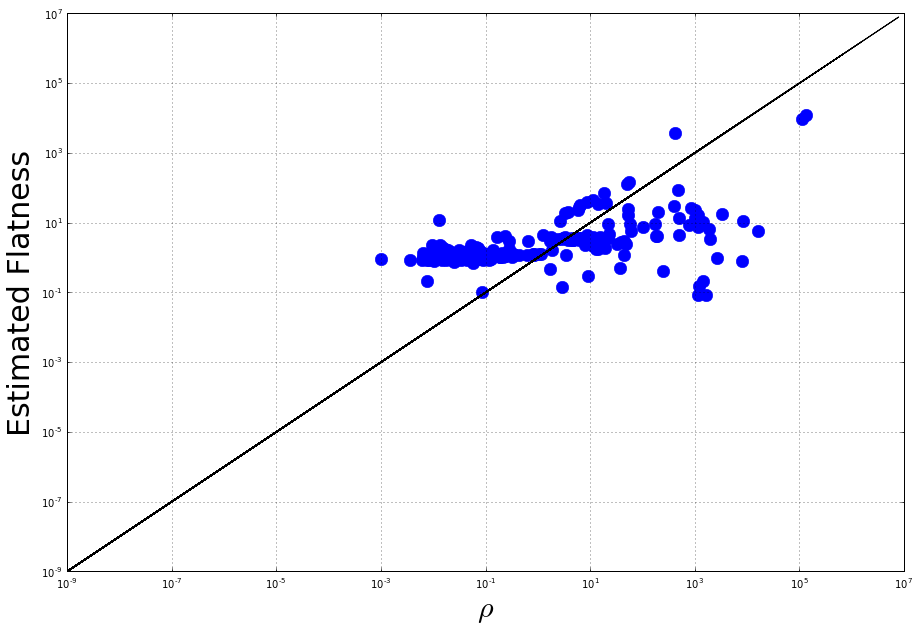

In [232]:
# General format for plotting different parameters versus each other 

plt.figure()
ax = plt.gca()
x = 'tE_ml'
y = 'b_ml'
C =1
#plt.plot(np.abs(info[x][info.tE_trapezoid>2]), np.abs(info[y][info.tE_trapezoid>2]),'r.', markersize=25)


#plt.plot(np.abs(info[x][info.rho<0.1]), C*np.abs(info[y][info.rho<0.1]),'g.', markersize=25)
plt.plot(np.abs(info[x][info.rho>0.1]), C*np.abs(info[y][info.rho>0.1]),'b.', markersize=25)


plt.plot(np.abs(info[x]), np.abs(info[x]),'k-', markersize=25)
# plt.plot(np.abs(info[x]), np.abs(info[x])+0.05,'k-', markersize=25)
# plt.plot(np.abs(info[x]), np.abs(info[x])-0.05,'k-', markersize=25)



# plt.plot(np.abs(info[x][(info.tE<0.1) & (np.abs(info.tE_trapezoid/4.)<(np.abs(info.tE)+0.05)) & (np.abs(info.tE_trapezoid/4.)>(np.abs(info.tE)-0.05)) & (info.tE_trapezoid !=0)]), 
#          C*np.abs(info[y][(info.tE<0.1) & (np.abs(info.tE_trapezoid/4.)<(np.abs(info.tE)+0.05)) & (np.abs(info.tE_trapezoid/4.)>(np.abs(info.tE)-0.05)) & (info.tE_trapezoid !=0)]),'b.', markersize=25)



# axs[0, 1].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
# axs[0, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off',length=0)

# axs[0, 0].tick_params(axis='y',which='both', labelsize=12)
# axs[1, 0].tick_params(axis='both',which='both', labelsize=12)
# axs[1, 1].tick_params(axis='x',which='both', labelsize=12)

plt.yscale('log')
plt.xscale('log')

# ax.set_xticklabels( ['', 0.5, 1.0, 1.5,2.0],rotation = 0, fontsize = 22)
# ax.set_yticklabels( ['',0.5, 0.1,1.5,2.0,2.5,3],rotation = 90, fontsize = 22)


# axs[0, 0].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
# axs[1, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off', length=0)

# plt.xlim(0.01,2)
# plt.ylim(0.03,3)

plt.grid()

# plt.title('Trapezoidal Estimation of $t_E$ Versus True Values of $t_E$', size=30) 

plt.xlabel(r'$\rho$',size=30)
plt.ylabel( 'Estimated Flatness',size=30)

fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
#fig.savefig('tE_FFP_Trapezoid.png')

In [188]:
info['t0_ml'] = info['t0_ml'].values-2458234

In [189]:
info['tE_ml'] = np.abs(info['tE_ml'])

In [202]:
x = np.array(result_FFP['b_ml'])

In [203]:
len(x[x>1])

734

In [105]:
t= t-2458234
index = []
for i in range(0,len(info)-1):
    
    if (info.t0_ml[i] <0) or (info.b_ml[i] >5):
        index.append(i)
    

In [106]:
info_new = info.drop(index)


In [107]:
len(info_new)

463

In [421]:
info[['name','rho','tE', 'tE_ml_bell']][(info.rho>0.8) & (info.type==3) ]

,name,rho,tE,tE_ml_bell
2876,mag.dcnormffp_0_82_107.det.lc.W149,0.910543,0.394506,0.000000
3092,mag.dcnormffp_0_82_323.det.lc.W149,1.761050,0.155615,0.280519
3112,mag.dcnormffp_0_82_343.det.lc.W149,1.059950,0.014420,0.000000
3330,mag.dcnormffp_0_82_561.det.lc.W149,2.593130,0.029163,0.000000
3350,mag.dcnormffp_0_82_581.det.lc.W149,3.134420,0.057991,0.000000
3630,mag.dcnormffp_0_82_861.det.lc.W149,0.875754,0.066953,0.000000
3649,mag.dcnormffp_0_82_880.det.lc.W149,0.826663,0.072663,0.000000
3851,mag.dcnormffp_0_82_1082.det.lc.W149,0.987937,0.025364,0.000000
3874,mag.dcnormffp_0_82_1105.det.lc.W149,4.189380,1.154220,0.000000
3929,mag.dcnormffp_0_82_1160.det.lc.W149,0.968254,0.042244,0.000000
